![Segmentation](Project_4_pic_1.jpg)

<span style="font-size:24px">**Image Segmentation**</span>

## 1 Installing Dependencies

We are tasked with solving the problem of medical image segmentation.

---


1. To begin, we will download the dataset: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>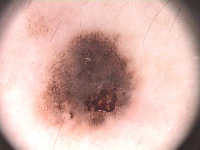</td><td>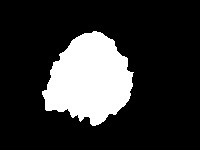</td></tr></table>

2. Extract the .rar file.
3. Note that the `PH2 Dataset images` folder should be in the same location as the IPython notebook.

These are photographs of two types of skin lesions: **melanoma** and **nevus**.
We will not classify them but rather **segment** them.

In [ ]:
!wget -c https://www.dropbox.com/s/uq438szypt1n7nr/PH2Dataset.rar

--2022-12-04 16:12:10--  https://www.dropbox.com/s/uq438szypt1n7nr/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.64.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.64.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/uq438szypt1n7nr/PH2Dataset.rar [following]
--2022-12-04 16:12:11--  https://www.dropbox.com/s/raw/uq438szypt1n7nr/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4941aafb1a81d34410b8cb6498.dl.dropboxusercontent.com/cd/0/inline/Bx-8NIqgif_MIuArOc1aeq2Gh1La8MwzssUuIH4KSBb1psZs6C77nQwD6D1FMPQcGMCGp-mFi11FYt-krs5OeZ8pzwm-axFzLeu7lssRABKILjyJT4A4ygnJVIjCeqe3EVN8b0g7Lyfi-VppwJqsrUJJSK-OzUTMYdtXDG0Amh8f8Q/file# [following]
--2022-12-04 16:12:12--  https://uc4941aafb1a81d34410b8cb6498.dl.dropboxusercontent.com/cd/0/inline/Bx-8NIqgif_MIuArOc1aeq2Gh1La8MwzssUuIH4KSBb1psZs6C77nQwD6D1FMPQcGMCGp-m

In [ ]:
!ls

 PH2Dataset.rar  'PH2Dataset.rar?dl=0'	 sample_data  'view?usp=sharing'


In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

The structure of our dataset is as follows:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Here, `X.bmp` represents the image to be segmented, and `X_lesion.bmp` represents the segmentation result.

To load the dataset, you can use skimage:  [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

The images have different sizes. Let's resize them to $256\times256$ pixels. You can use [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) function to resize the images.
This function also automatically normalizes the images to the range $[0,1]$.

In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

To make sure everything is correct, we will draw a few images.

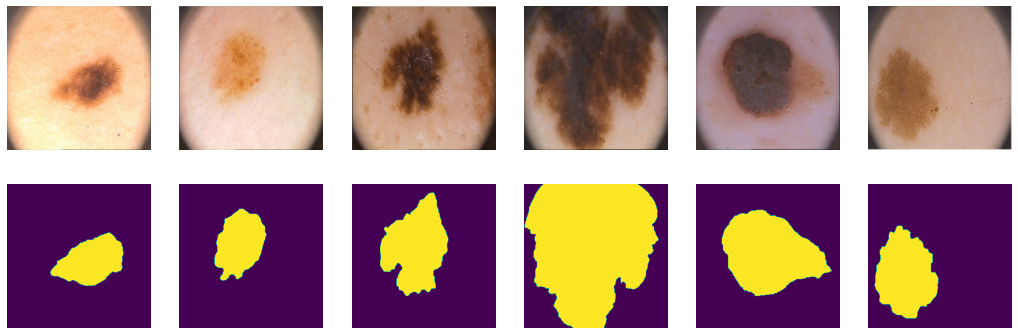

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

We will divide our 200 images into 100 for training, 50 for validation, and 50 for testing, respectively.

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


### 1.1 PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Implementation of Different Architectures
Let's write several neural network architectures for solving the task of semantic segmentation. We will compare them based on their performance on the test set and experiment with different loss functions for them.

## 2 SegNet

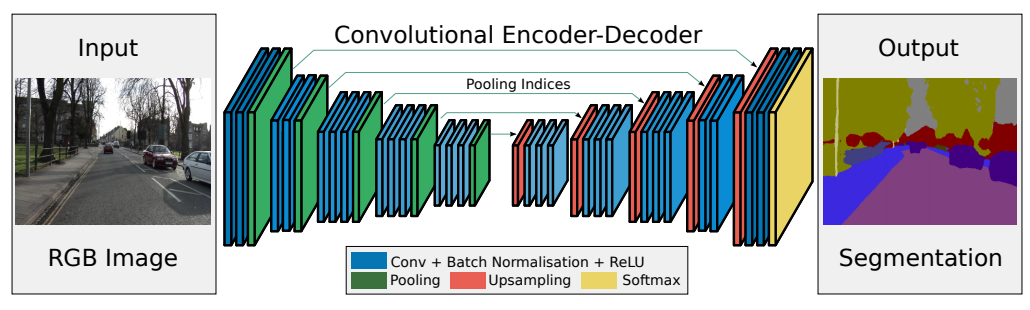

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
import torchvision

The first half of SegNet is built on VGG16, as mentioned in the article above. So let's load VGG16 and rewrite its layers in our code.

In [ ]:
torchvision.models.vgg16()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Let's remove the bottleneck since it is not present in VGG16. Instead, VGG16 consists of 5 convolutional modules and 5 deconvolutional modules.

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
        nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True) # 32 -> 16
        self.enc_conv4 = nn.Sequential(
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True)
        )
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True)
        )
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True)
        )
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
        nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True)
        )
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
        nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True)
        )
        self.upsample4 = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0)
        self.dec_conv4 = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        )

    def forward(self, x):
        # encoder
        e0, index0 = self.pool0(self.enc_conv0(x))
        e1, index1 = self.pool1(self.enc_conv1(e0))
        e2, index2 = self.pool2(self.enc_conv2(e1))
        e3, index3 = self.pool3(self.enc_conv3(e2))
        e4, index4 = self.pool4(self.enc_conv4(e3))

        # decoder
        d0 = self.dec_conv0(self.upsample0(e4, index4))
        d1 = self.dec_conv1(self.upsample1(d0, index3))
        d2 = self.dec_conv2(self.upsample2(d1, index2))
        d3 = self.dec_conv3(self.upsample3(d2, index1))
        d4 = self.dec_conv4(self.upsample4(d3, index0))   # no activation
        return d4

### 2.1 Metric

In this section, the following metric is proposed to evaluate the quality:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

The intersection (A ∩ B) consists of pixels found in both the prediction mask and the ground truth mask, while the union (A ∪ B) simply consists of all pixels found either in the prediction mask or the target mask.

For example, let's look at the ground truth (left) and the prediction (right):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Then the intersection and union would look like this:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):

    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # we smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # this is equal to comparing with thresolds
    
    return thresholded

### 2.2 Loss Function

Equally important to architectural design is the choice of an **optimizer and a loss function**.

The loss function represents what we are trying to minimize. Several loss functions can be used for binary semantic segmentation tasks.

A popular choice for binary segmentation is **binary cross-entropy**, which is defined as:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

where $y$ represents the desired target and $\hat y$ is the model's output. $\sigma$ - is the [*logistic* function](https://en.wikipedia.org/wiki/Sigmoid_function), which converts a real number $\mathbb R$ into a probability range of $[0,1]$.

However, this loss suffers from numerical instability issues. In particular, $\lim_{x\rightarrow0}\log(x)=\infty$ which leads to instability during optimization. It is recommended to use the [simplified version](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). This function is equivalent to the first one but is less prone to numerical instability:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real, y_pred):
    loss_bce = torch.mean(y_pred - y_real*y_pred + torch.log(1+torch.exp(-y_pred)))
    return loss_bce

### 2.3 Training

We will define a training loop in a function so that we can reuse it.

We will add train_loss_history, val_loss_history, and iou_score_history to the train function and update them during the training loop. This will allow us to plot the loss and score curves later on.

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    train_loss_history = []
    val_loss_history = []
    iou_score_history = []

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)

        train_loss_history.append(avg_loss)

        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device)).detach().to('cpu') # detach and put into cpu

        val_loss_history.append(loss_fn(Y_val, Y_hat))
        iou_score_history.append(score_model(model, iou_pytorch, data_val))

        # visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

    return train_loss_history, val_loss_history, iou_score_history

### 2.4 Inference

After training the model, we can use this function for making predictions on new data:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        Y_pred = Y_pred > 0.5
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

        #clear the memory
        del X_batch
        del Y_label
        del Y_pred

    torch.cuda.empty_cache()

    return scores/len(data)

### 2.5 The main focus: training

In [ ]:
model = SegNet().to(device)

70 epochs and the learning rate were determined experimentally, and they provide the best results with relatively short training time.

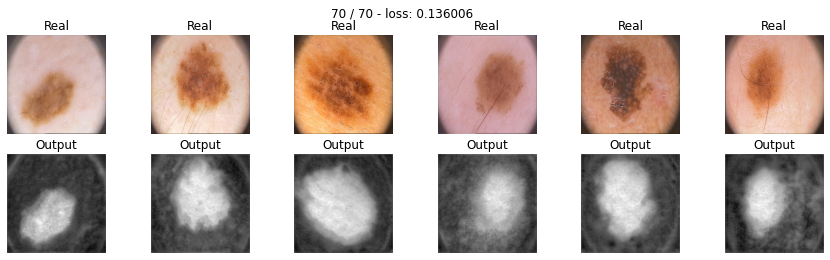

In [ ]:
max_epochs = 70
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
train_loss_history, val_loss_history, iou_score_history =\
train(model, optim, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model, iou_pytorch, data_val)

0.6599999666213989

0.66 intersection over union. Not bad.

Now let's visualize the training.

In [ ]:
train_loss_history = torch.Tensor(train_loss_history)
val_loss_history = torch.Tensor(val_loss_history)
iou_score_history = torch.Tensor(iou_score_history)

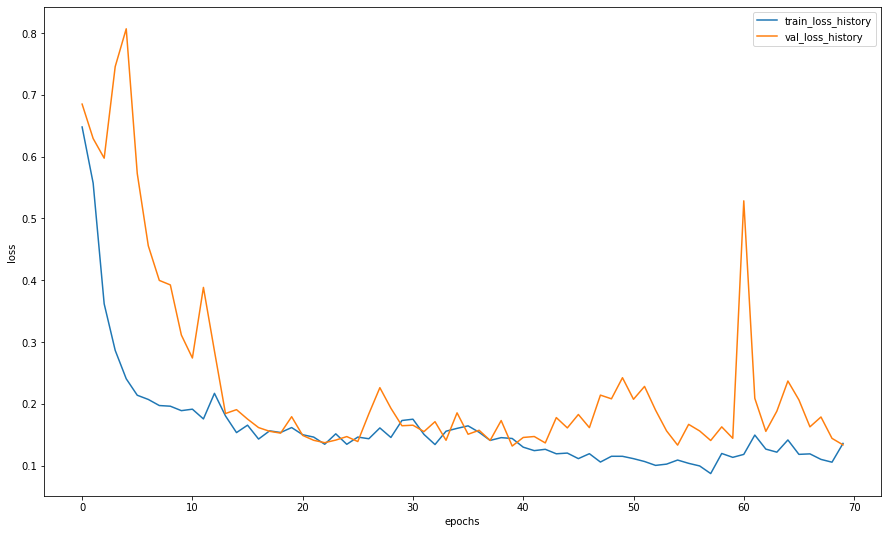

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(train_loss_history, label="train_loss_history")
plt.plot(val_loss_history, label="val_loss_history")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

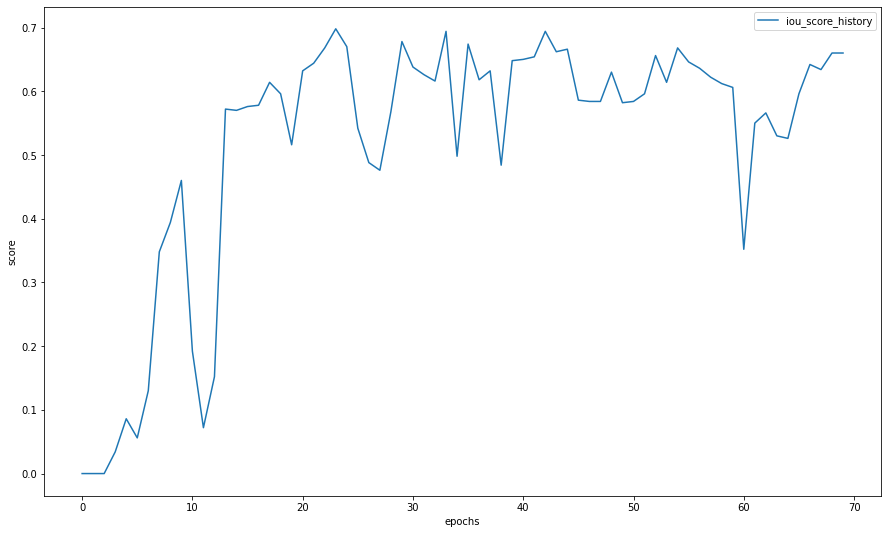

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(iou_score_history, label="iou_score_history")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

### 2.6 Additional loss functions

Let's implement two additional loss functions: **DICE, Focal loss and Tversky loss**.

**1. Dice coefficient:** Given two masks $X$ and $Y$, the DICE coefficient is a common metric for measuring the distance between these two masks and is defined as:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

This function is not differentiable, but differentiability is a necessary property for gradient-based optimization. In this case, we can approximate it using:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Here, it is necessary to apply the sigmoid activation function, unlike in the simplified BCE loss. Training does not work without sigmoid.

In [ ]:
def dice_loss(y_real, y_pred):
    y_pred = torch.sigmoid(y_pred)
    num = torch.sum(2 * y_pred * y_real)
    den =  torch.sum(y_pred + y_real)
    res = 1 - (num / den)
    return res

Performing testing:

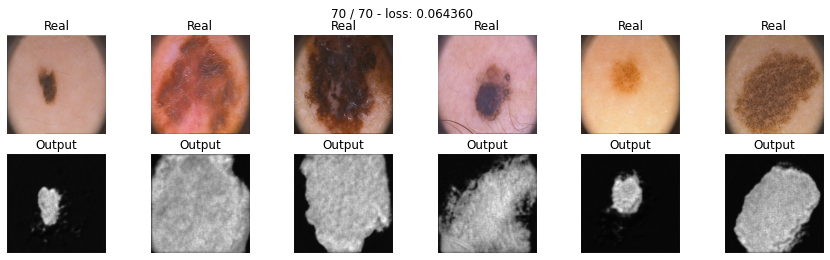

In [ ]:
model_dice = SegNet().to(device)
max_epochs = 70
optimaizer = torch.optim.Adam(model_dice.parameters(), lr=1e-3)
train_loss_history, val_loss_history, iou_score_history =\
train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_dice, iou_pytorch, data_val)

0.60999995470047

The score is slightly worse compared to using BCE loss.

In [ ]:
train_loss_history = torch.Tensor(train_loss_history)
val_loss_history = torch.Tensor(val_loss_history)
iou_score_history = torch.Tensor(iou_score_history)

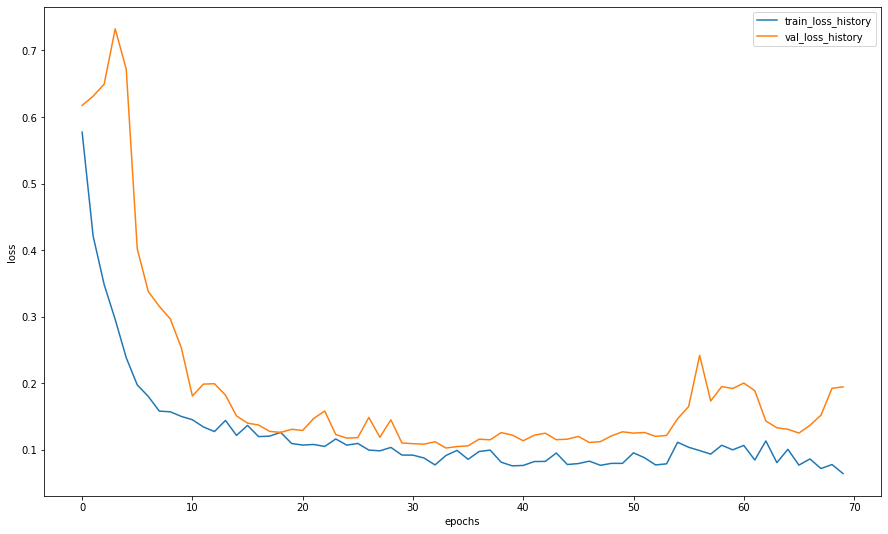

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(train_loss_history, label="train_loss_history")
plt.plot(val_loss_history, label="val_loss_history")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

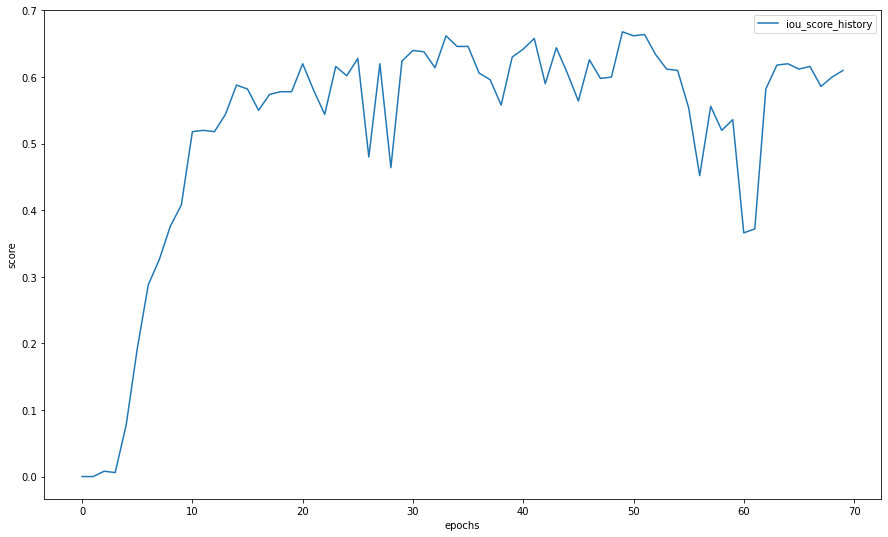

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(iou_score_history, label="iou_score_history")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Okay, now we know how to calculate BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

The issue with this loss is that it tends to favor the **majority** class (background) over the **minority** class (foreground). Therefore, it is common to apply weight coefficients to each class:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Traditionally, the weight $\alpha_i$ is defined as the inverse frequency of the class of that pixel $i$, so that observations of the minority class carry more weight compared to the majority class.

Another recent addition is the weighted pixel variant, which weights each pixel based on the confidence level we have in predicting that pixel.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Let's set $\gamma=2$ as a fixed value.

In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_predss = torch.clamp(torch.sigmoid(y_pred), min=eps, max=1-eps)
    your_loss =  -torch.mean((1 - y_predss) ** gamma * y_real * torch.log(y_predss)\
                             + (1 - y_real) * torch.log(1 - y_predss))
    return your_loss

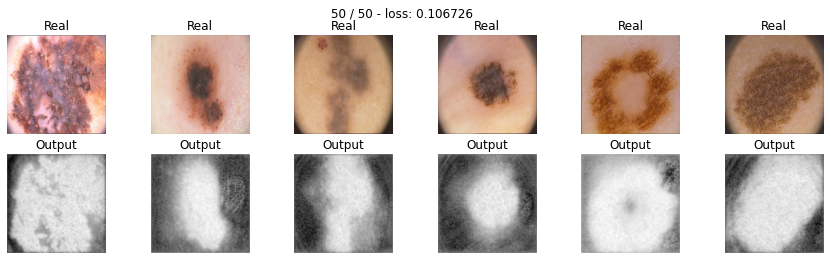

In [ ]:
model_focal = SegNet().to(device)

# on 70 epochs, the model with focal loss overfit heavily, so let's train it for 50 epochs instead
max_epochs = 50
optimaizer = torch.optim.Adam(model_focal.parameters(), lr=1e-3)
train_loss_history, val_loss_history, iou_score_history =\
train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_focal, iou_pytorch, data_val)

0.34599997103214264

No matter how hard I tried, focal loss shows worse results for SegNet.

In [ ]:
train_loss_history = torch.Tensor(train_loss_history)
val_loss_history = torch.Tensor(val_loss_history)
iou_score_history = torch.Tensor(iou_score_history)

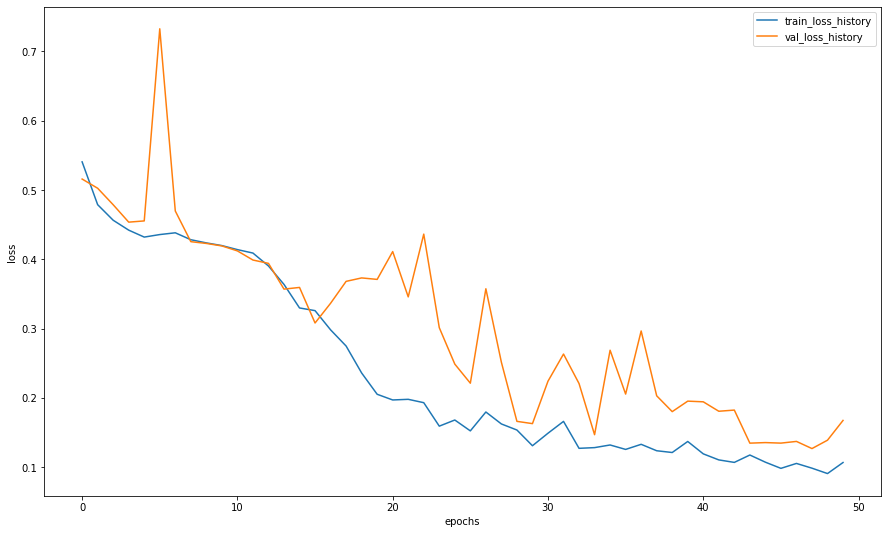

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(train_loss_history, label="train_loss_history")
plt.plot(val_loss_history, label="val_loss_history")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

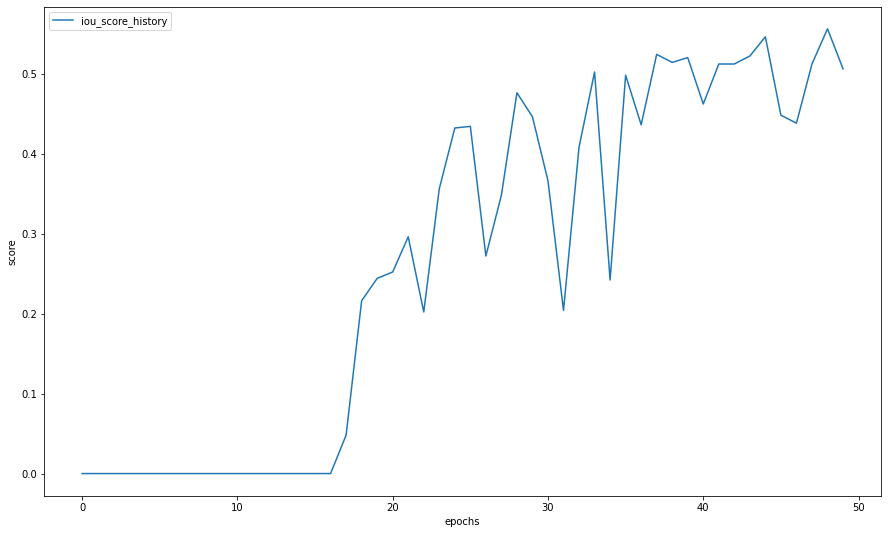

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(iou_score_history, label="iou_score_history")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

**3. TverskyLoss:**
* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

In [ ]:
class BinaryTverskyLoss(nn.Module):

    def __init__(self, alpha=0.3, beta=0.7, ignore_index=None, reduction='mean'):
        super(BinaryTverskyLoss, self).__init__()
        
        self.alpha = alpha
        self.beta = beta
        self.ignore_index = ignore_index
        self.smooth = 10
        self.reduction = reduction
        s = self.beta + self.alpha
        if s != 1:
            self.beta = self.beta / s
            self.alpha = self.alpha / s

    def forward(self, target, output, mask=None):
        batch_size = output.size(0)
        bg_target = 1 - target
        if self.ignore_index is not None:
            valid_mask = (target != self.ignore_index).float()
            output = output.float().mul(valid_mask)
            target = target.float().mul(valid_mask)
            bg_target = bg_target.float().mul(valid_mask)

        output = torch.sigmoid(output).view(batch_size, -1)
        target = target.view(batch_size, -1)
        bg_target = bg_target.view(batch_size, -1)

        P_G = torch.sum(output * target, 1)  # TP
        P_NG = torch.sum(output * bg_target, 1)  # FP
        NP_G = torch.sum((1 - output) * target, 1)  # FN

        tversky_index = P_G / (P_G + self.alpha * P_NG + self.beta * NP_G + self.smooth)

        loss = 1. - tversky_index
        
        if self.reduction == 'none':
            loss = loss
        elif self.reduction == 'sum':
            loss = torch.sum(loss)
        else:
            loss = torch.mean(loss)
        return loss

In [ ]:
tversky_loss = BinaryTverskyLoss()

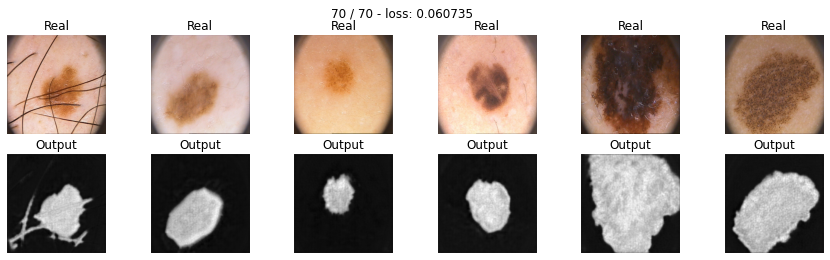

In [ ]:
model_tversky = SegNet().to(device)
max_epochs = 70
optimaizer = torch.optim.Adam(model_tversky.parameters(), lr=1e-3)
train_loss_history, val_loss_history, iou_score_history =\
train(model_tversky, optimaizer, tversky_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_tversky, iou_pytorch, data_val)

0.6780000030994415

Wow! 0.67, the best score on SegNet.

In [ ]:
train_loss_history = torch.Tensor(train_loss_history)
val_loss_history = torch.Tensor(val_loss_history)
iou_score_history = torch.Tensor(iou_score_history)

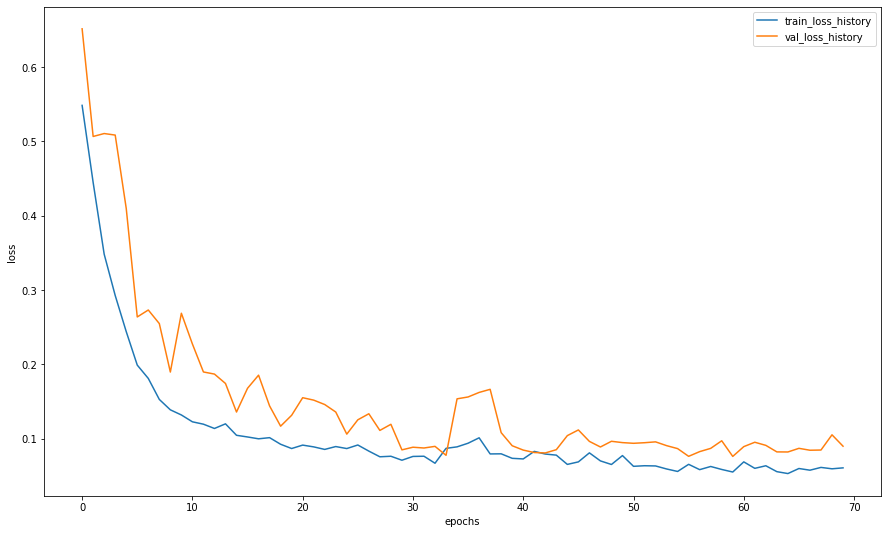

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(train_loss_history, label="train_loss_history")
plt.plot(val_loss_history, label="val_loss_history")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

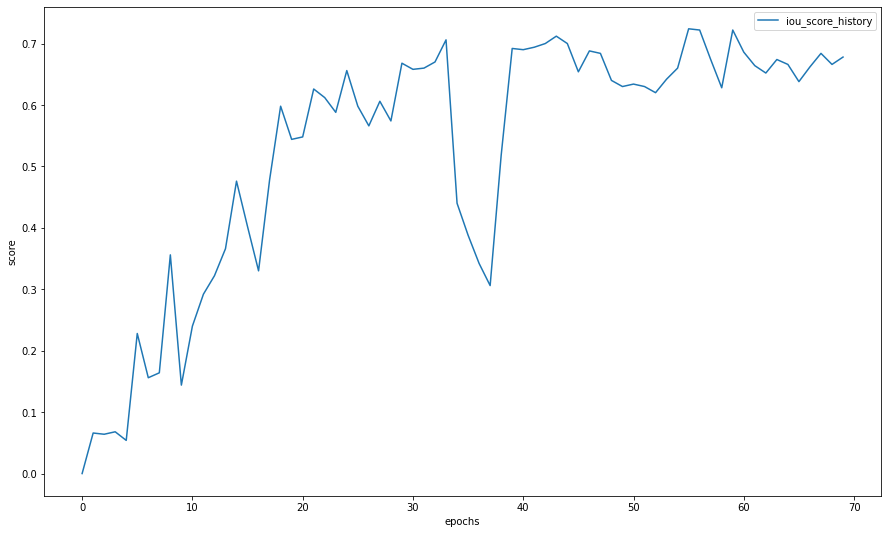

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(iou_score_history, label="iou_score_history")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

## 3. U-Net

[**U-Net**](https://arxiv.org/abs/1505.04597) is a neural network architecture that takes an image as input and produces an output image. It was initially designed for semantic segmentation (which is how we will be using it), but it has been so successful that it has been widely adopted in other contexts as well. When given a medical image as input, it will produce a grayscale image where the intensity of each pixel represents the probability of that pixel belonging to the region of interest we are interested in.

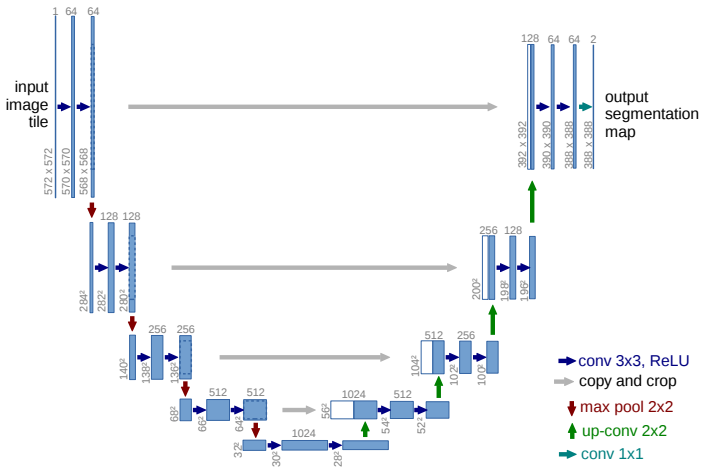

In our architecture, we still have an encoder and a decoder like in **SegNet**, but the distinctive feature of the U-Net model is the presence of **skip connections** that connect corresponding parts of the encoder and decoder. This means that in order to pass a tensor to the input of the decoder, we concatenate the symmetric output from the encoder with the output from the previous layer of the decoder.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=(3, 3), padding=(1, 1)),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
        nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # 32 -> 16
        
        # bottleneck
        self.bottleneck_conv = nn.Sequential(
        nn.Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(1024),
        nn.ReLU(inplace=True),
        nn.Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(1024),
        nn.ReLU(inplace=True)
        )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(32) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
        nn.Conv2d(1024 + 512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        )
        self.upsample1 = nn.Upsample(64) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
        nn.Conv2d(512 + 256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        )
        self.upsample2 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
        nn.Conv2d(256 + 128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True)
        )
        self.upsample3 = nn.Upsample(256)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
        nn.Conv2d(128 + 64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3))

        # decoder
        d0 = self.upsample0(b)
        d0 = torch.cat([d0, e3], dim=1)
        d0 = self.dec_conv0(d0)
        
        d1 = self.upsample1(d0)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec_conv1(d1)

        d2 = self.upsample2(d1)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec_conv2(d2)

        d3 = self.upsample3(d2)
        d3 = torch.cat([d3, e0], dim=1)
        d3 = self.dec_conv3(d3)# no activation
        
        return d3

In [ ]:
unet_model = UNet().to(device)

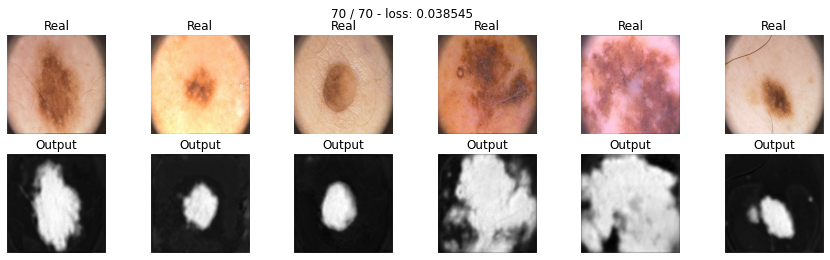

In [ ]:
train_loss_history, val_loss_history, iou_score_history =\
train(unet_model, torch.optim.Adam(unet_model.parameters(), lr=1e-4), bce_loss, 70, data_tr, data_val)

In [ ]:
score_model(unet_model, iou_pytorch, data_val)

0.7679999768733978

0.77. A significant improvement in performance for U-Net with BCE loss compared to SegNet. However, it's worth trying other loss functions as well.

In [ ]:
train_loss_history = torch.Tensor(train_loss_history)
val_loss_history = torch.Tensor(val_loss_history)
iou_score_history = torch.Tensor(iou_score_history)

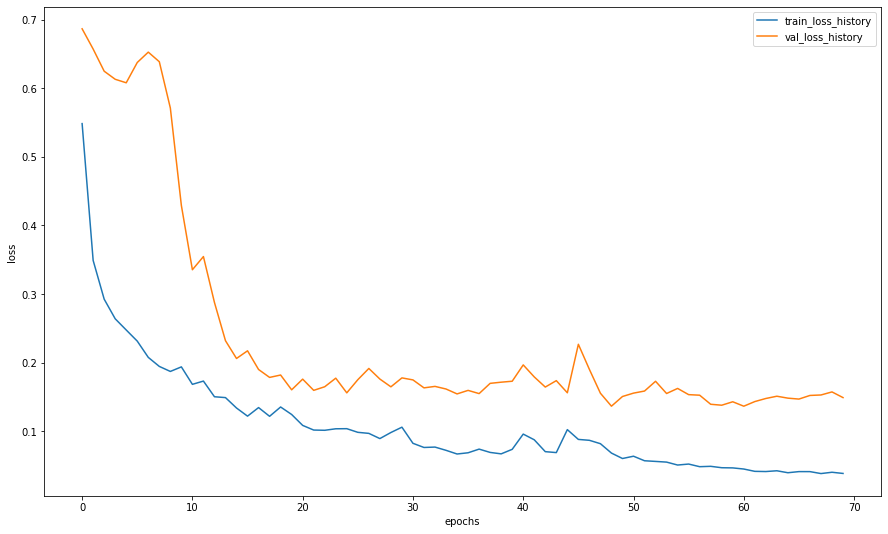

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(train_loss_history, label="train_loss_history")
plt.plot(val_loss_history, label="val_loss_history")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

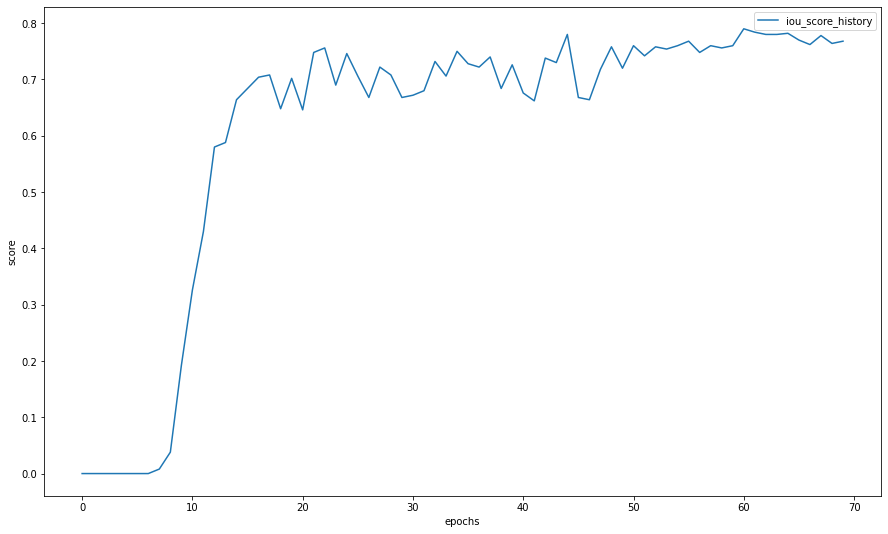

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(iou_score_history, label="iou_score_history")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

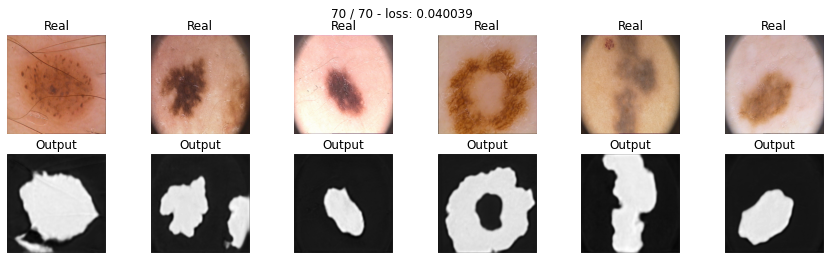

In [ ]:
unet_model = UNet().to(device)
train_loss_history, val_loss_history, iou_score_history =\
train(unet_model, torch.optim.Adam(unet_model.parameters(), lr=1e-4), dice_loss, 70, data_tr, data_val)

In [ ]:
score_model(unet_model, iou_pytorch, data_val)

0.7460000216960907

Slightly worse than with BCE loss.

In [ ]:
train_loss_history = torch.Tensor(train_loss_history)
val_loss_history = torch.Tensor(val_loss_history)
iou_score_history = torch.Tensor(iou_score_history)

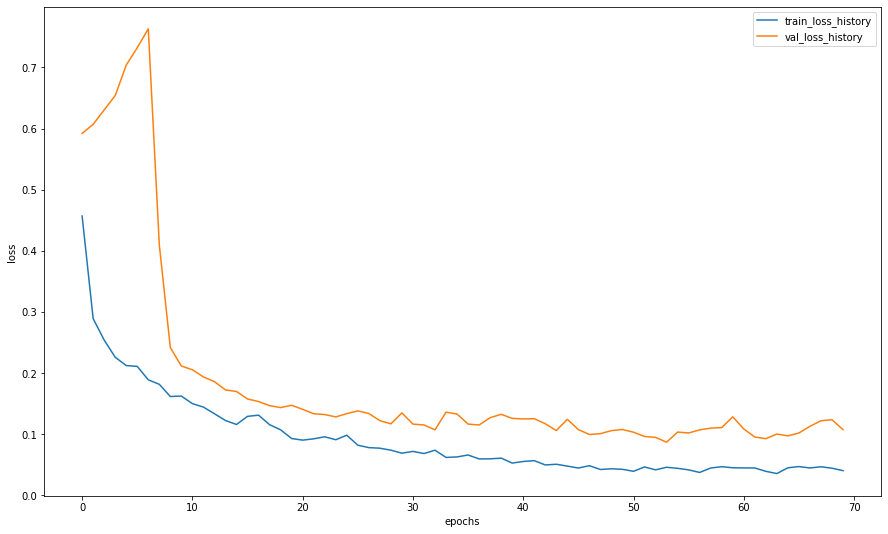

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(train_loss_history, label="train_loss_history")
plt.plot(val_loss_history, label="val_loss_history")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

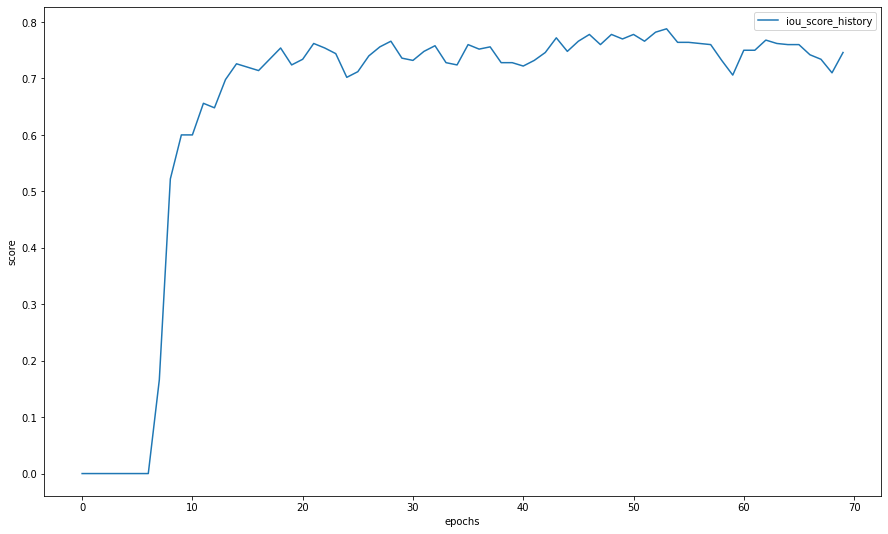

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(iou_score_history, label="iou_score_history")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

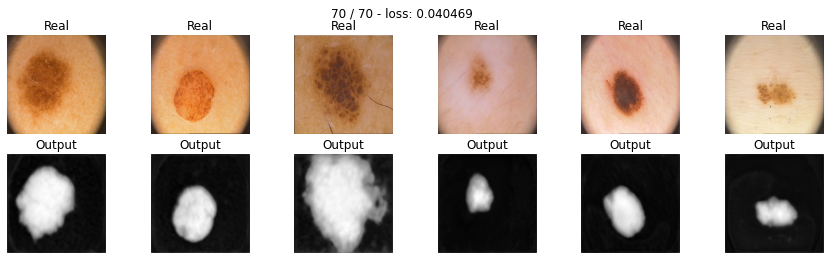

In [ ]:
unet_model = UNet().to(device)
train_loss_history, val_loss_history, iou_score_history = train(unet_model, torch.optim.Adam(unet_model.parameters(), lr=1e-4), focal_loss, 70, data_tr, data_val)

In [ ]:
score_model(unet_model, iou_pytorch, data_val)

0.7319999635219574

Focal loss unexpectedly performed well with U-Net compared to SegNet.

In [ ]:
train_loss_history = torch.Tensor(train_loss_history)
val_loss_history = torch.Tensor(val_loss_history)
iou_score_history = torch.Tensor(iou_score_history)

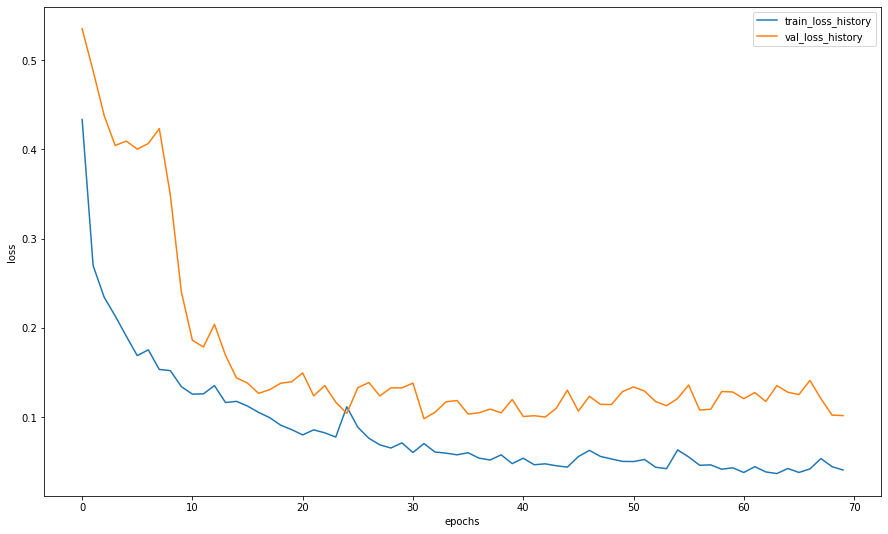

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(train_loss_history, label="train_loss_history")
plt.plot(val_loss_history, label="val_loss_history")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

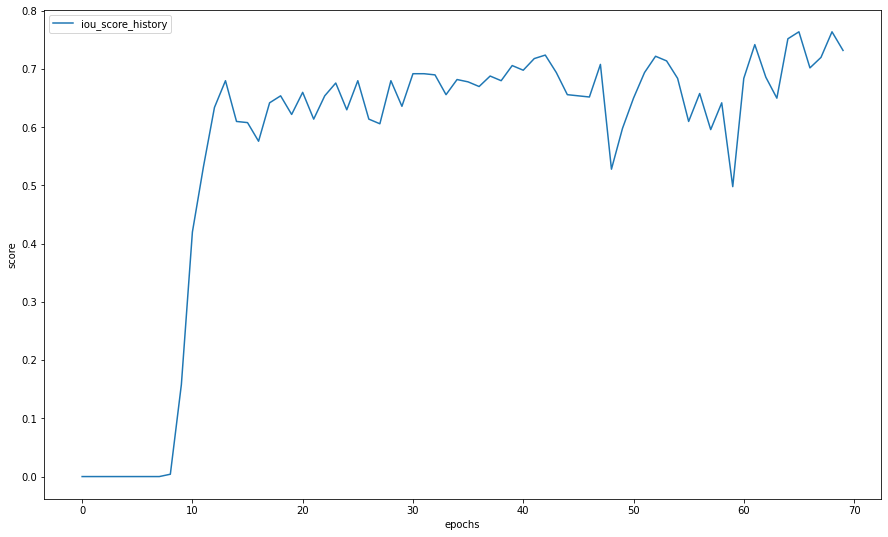

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(iou_score_history, label="iou_score_history")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

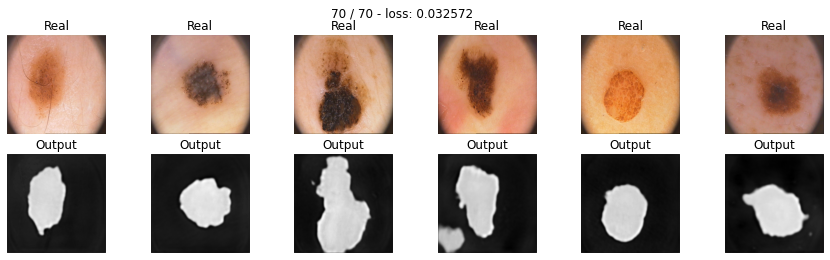

In [ ]:
unet_model = UNet().to(device)
train_loss_history, val_loss_history, iou_score_history = train(unet_model, torch.optim.Adam(unet_model.parameters(), lr=1e-4), tversky_loss, 70, data_tr, data_val)

In [ ]:
score_model(unet_model, iou_pytorch, data_val)

0.7600000202655792

This score is similar to the score with BCE loss.

In [ ]:
train_loss_history = torch.Tensor(train_loss_history)
val_loss_history = torch.Tensor(val_loss_history)
iou_score_history = torch.Tensor(iou_score_history)

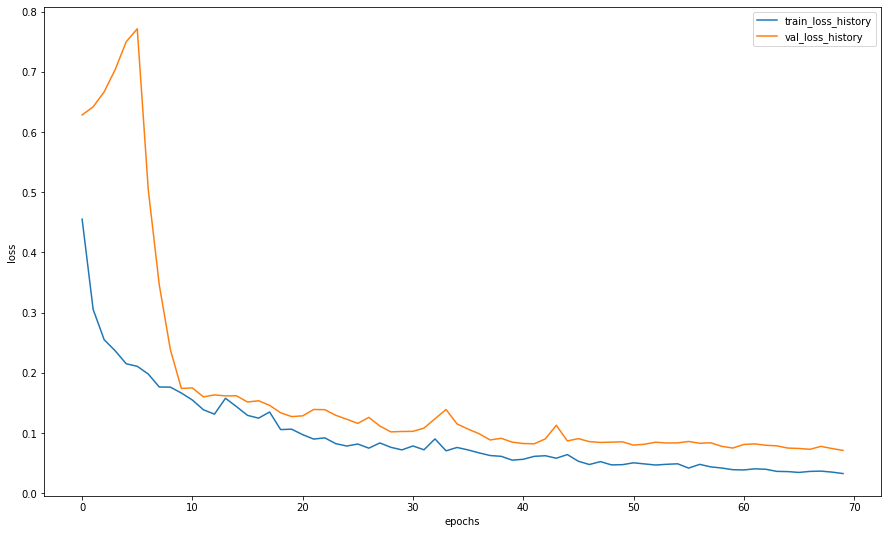

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(train_loss_history, label="train_loss_history")
plt.plot(val_loss_history, label="val_loss_history")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

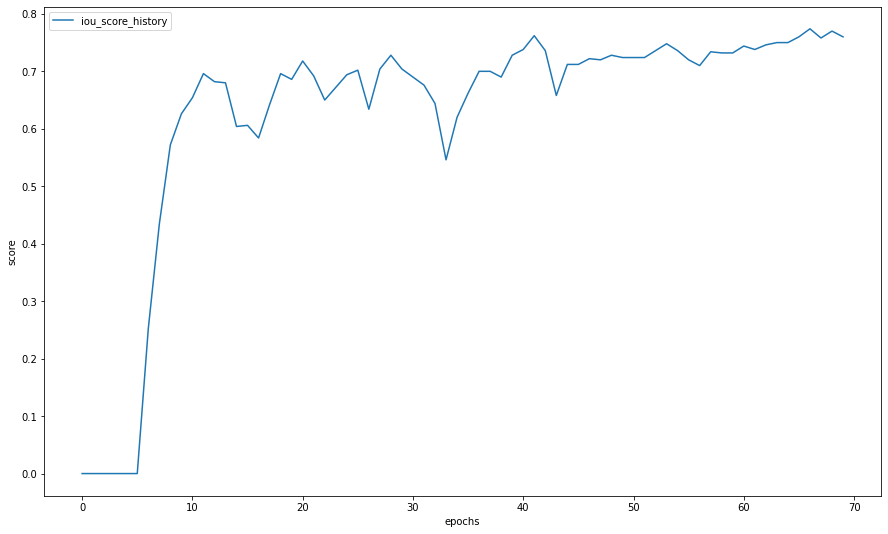

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(iou_score_history, label="iou_score_history")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

Let's modify the model by changing the pooling type:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Replace max-pooling with convolutions with stride=2 and upsampling with transpose convolutions with stride=2.

In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=(3, 3), padding=(1, 1)),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True)
        )
        self.pool0 = nn.Conv2d(64, 64, kernel_size=(2, 2), stride=(2, 2))  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True)
        )
        self.pool1 = nn.Conv2d(128, 128, kernel_size=(2, 2), stride=(2, 2)) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True)
        )
        self.pool2 = nn.Conv2d(256, 256, kernel_size=(2, 2), stride=(2, 2)) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
        nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True)
        )
        self.pool3 = nn.Conv2d(512, 512, kernel_size=(2, 2), stride=(2, 2)) # 32 -> 16
        
        # bottleneck
        self.bottleneck_conv = nn.Sequential(
        nn.Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(1024),
        nn.ReLU(inplace=True),
        nn.Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(1024),
        nn.ReLU(inplace=True)
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2)) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
        nn.Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        )
        self.upsample1 = nn.ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2)) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
        nn.Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        )
        self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
        nn.Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True)
        )
        self.upsample3 = nn.ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
        nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3))

        # decoder
        d0 = self.upsample0(b)
        d0 = torch.cat([d0, e3], dim=1)
        d0 = self.dec_conv0(d0)
        
        d1 = self.upsample1(d0)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec_conv1(d1)

        d2 = self.upsample2(d1)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec_conv2(d2)

        d3 = self.upsample3(d2)
        d3 = torch.cat([d3, e0], dim=1)
        d3 = self.dec_conv3(d3)# no activation
        
        return d3

In [ ]:
unet2_model = UNet2().to(device)

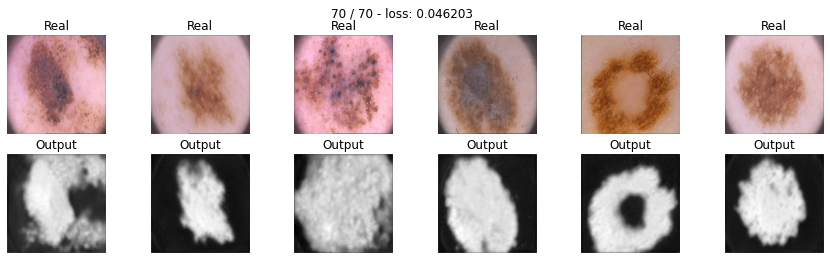

In [ ]:
train_loss_history, val_loss_history, iou_score_history =\
train(unet2_model, torch.optim.Adam(unet2_model.parameters(), lr=1e-4), bce_loss, 70, data_tr, data_val)

In [ ]:
score_model(unet2_model, iou_pytorch, data_val)

0.7540000379085541

We obtained a similar score compared to the score of U-Net v1.

In [ ]:
train_loss_history = torch.Tensor(train_loss_history)
val_loss_history = torch.Tensor(val_loss_history)
iou_score_history = torch.Tensor(iou_score_history)

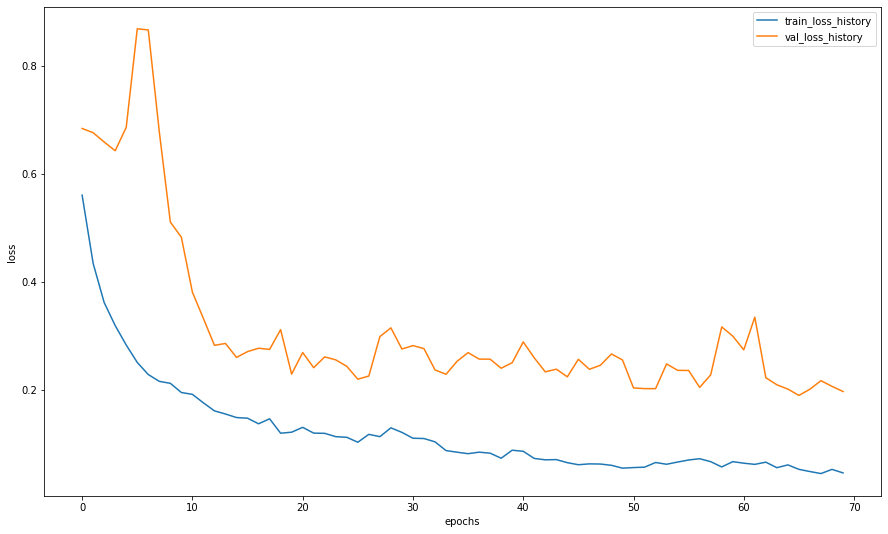

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(train_loss_history, label="train_loss_history")
plt.plot(val_loss_history, label="val_loss_history")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

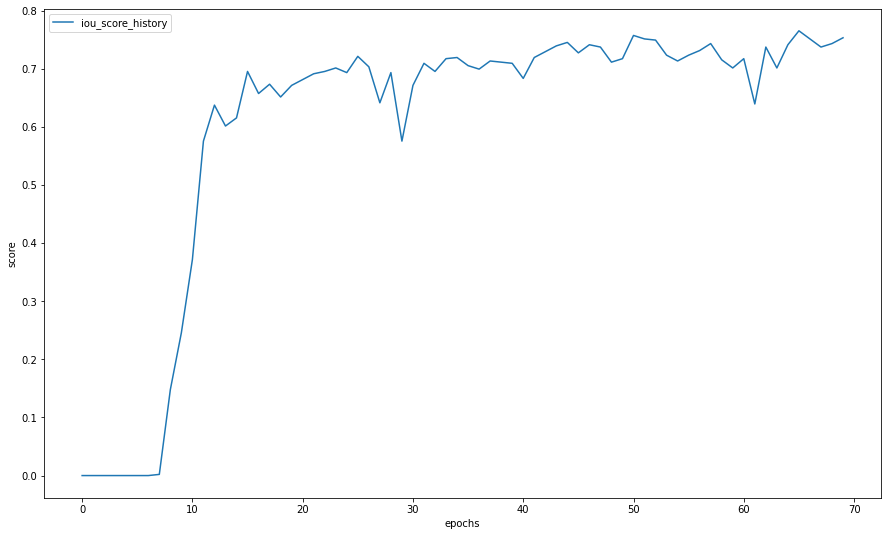

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(iou_score_history, label="iou_score_history")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

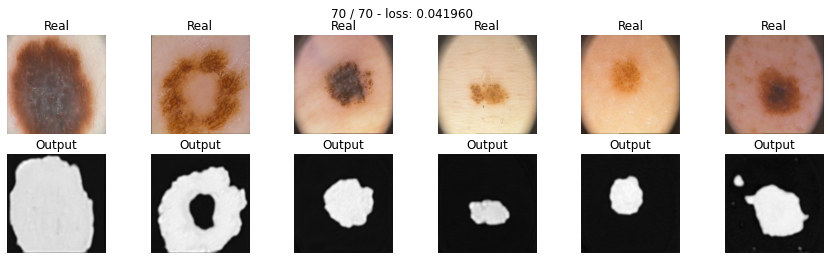

In [ ]:
unet2_model = UNet2().to(device)
train_loss_history, val_loss_history, iou_score_history =\
train(unet2_model, torch.optim.Adam(unet2_model.parameters(), lr=1e-4), dice_loss, 70, data_tr, data_val)

In [ ]:
score_model(unet2_model, iou_pytorch, data_val)

0.7599999904632568

In [ ]:
train_loss_history = torch.Tensor(train_loss_history)
val_loss_history = torch.Tensor(val_loss_history)
iou_score_history = torch.Tensor(iou_score_history)

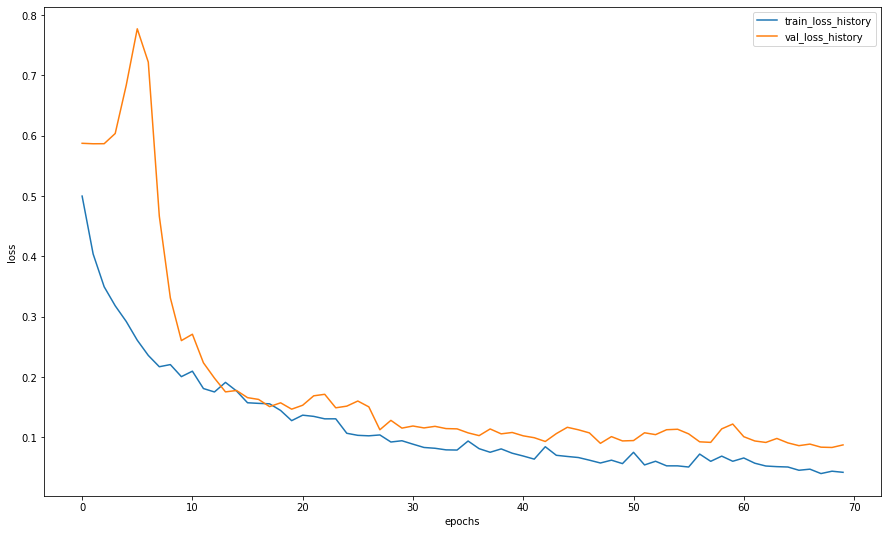

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(train_loss_history, label="train_loss_history")
plt.plot(val_loss_history, label="val_loss_history")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

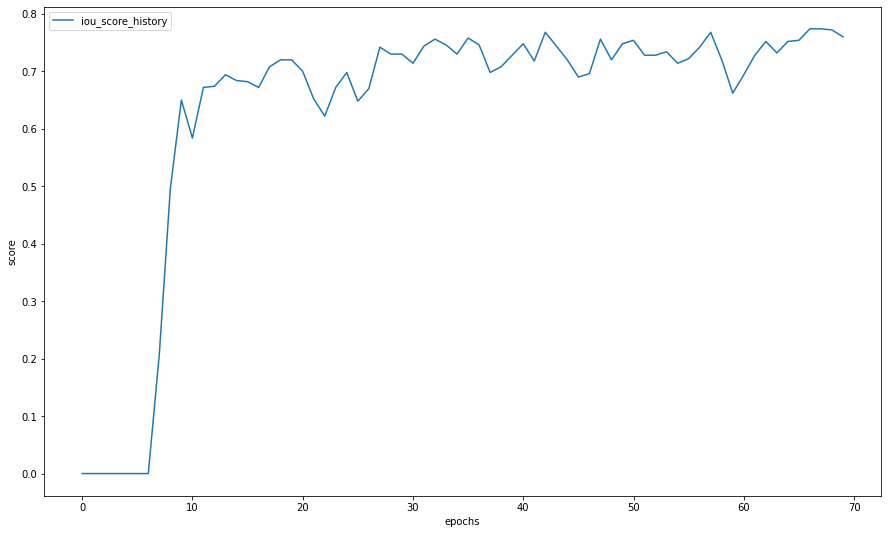

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(iou_score_history, label="iou_score_history")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

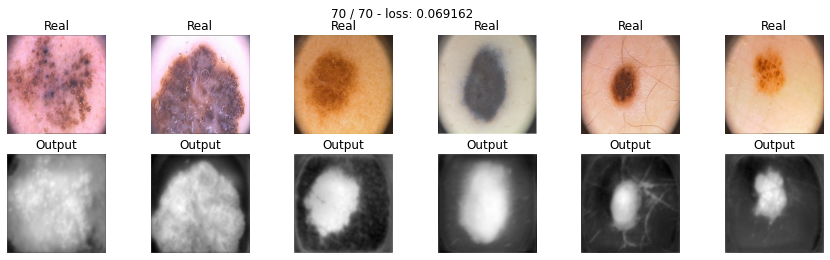

In [ ]:
unet2_model = UNet2().to(device)
train_loss_history, val_loss_history, iou_score_history =\
train(unet2_model, torch.optim.Adam(unet2_model.parameters(), lr=1e-4), focal_loss, 70, data_tr, data_val)

In [ ]:
score_model(unet2_model, iou_pytorch, data_val)

0.5379999577999115

It's interesting that the focal loss didn't perform well with this neural network architecture.

In [ ]:
train_loss_history = torch.Tensor(train_loss_history)
val_loss_history = torch.Tensor(val_loss_history)
iou_score_history = torch.Tensor(iou_score_history)

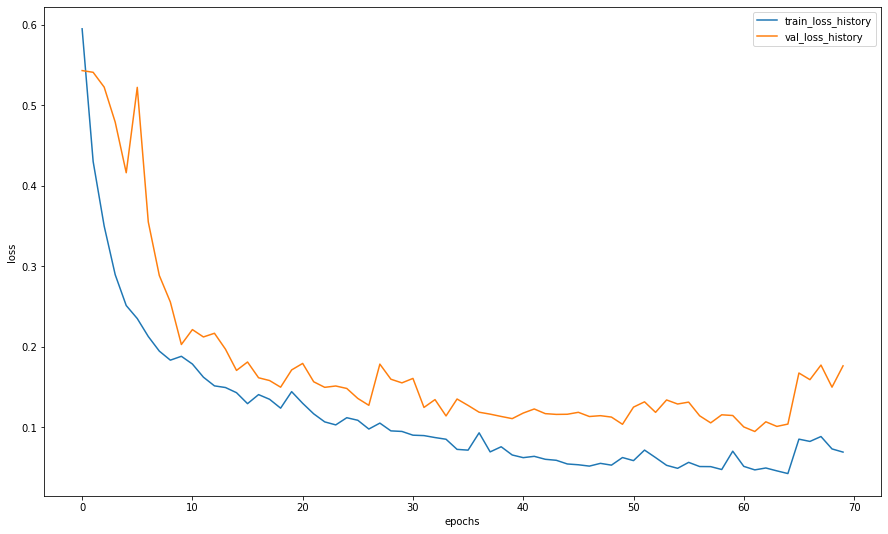

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(train_loss_history, label="train_loss_history")
plt.plot(val_loss_history, label="val_loss_history")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

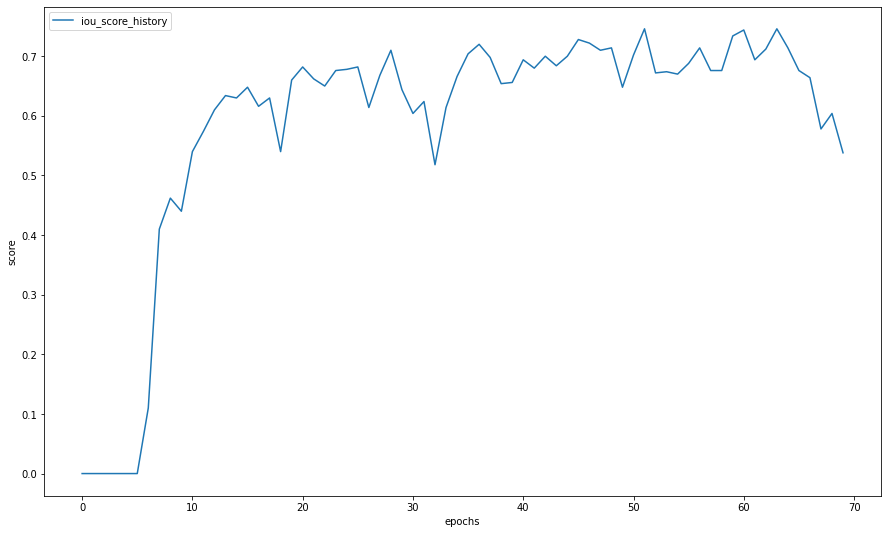

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(iou_score_history, label="iou_score_history")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

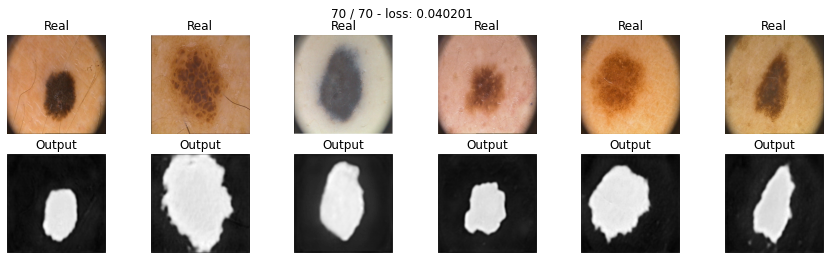

In [ ]:
unet2_model = UNet2().to(device)
train_loss_history, val_loss_history, iou_score_history =\
train(unet2_model, torch.optim.Adam(unet2_model.parameters(), lr=1e-4), tversky_loss, 70, data_tr, data_val)

In [ ]:
score_model(unet2_model, iou_pytorch, data_val)

0.7619999945163727

It's interesting to see that UNet2 consistently achieves a score around 0.75 with three different loss functions.

In [ ]:
train_loss_history = torch.Tensor(train_loss_history)
val_loss_history = torch.Tensor(val_loss_history)
iou_score_history = torch.Tensor(iou_score_history)

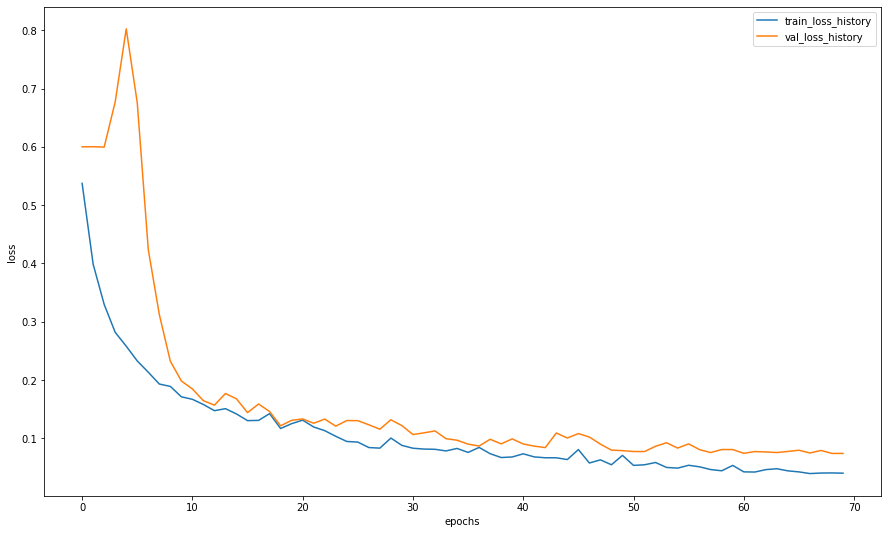

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(train_loss_history, label="train_loss_history")
plt.plot(val_loss_history, label="val_loss_history")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

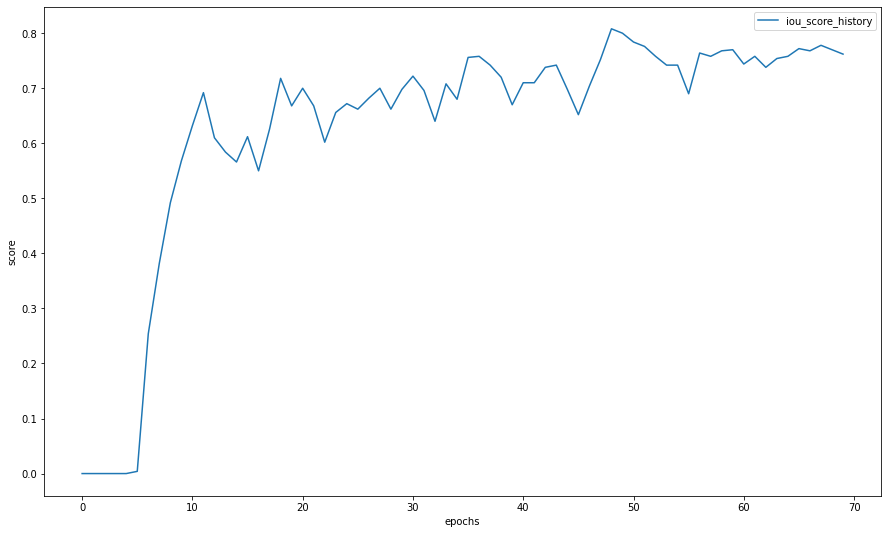

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(iou_score_history, label="iou_score_history")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

## 4 Conclusions

Which of the models performs the best on our dataset?

Let's start by comparing the obtained scores:

Segnet

bce - 0.660  
dice - 0.610  
focal - 0.346  
tversky - 0.678  

---
Unet

bce - 0.768  
dice - 0.746  
focal - 0.732  
tversky - 0.760  

---
Unet2

bce - 0.754  
dice - 0.760  
focal - 0.538  
tversky - 0.762

We can see that both Unet and Unet2 perform significantly better than SegNet across all loss functions. However, Unet2 shows a noticeable decrease in performance compared to Unet when using focal loss.

It's important to note that all models (except SegNet with focal loss) were trained for 70 epochs to ensure a fair comparison among them.

Let's take a look at the training and validation loss curves:

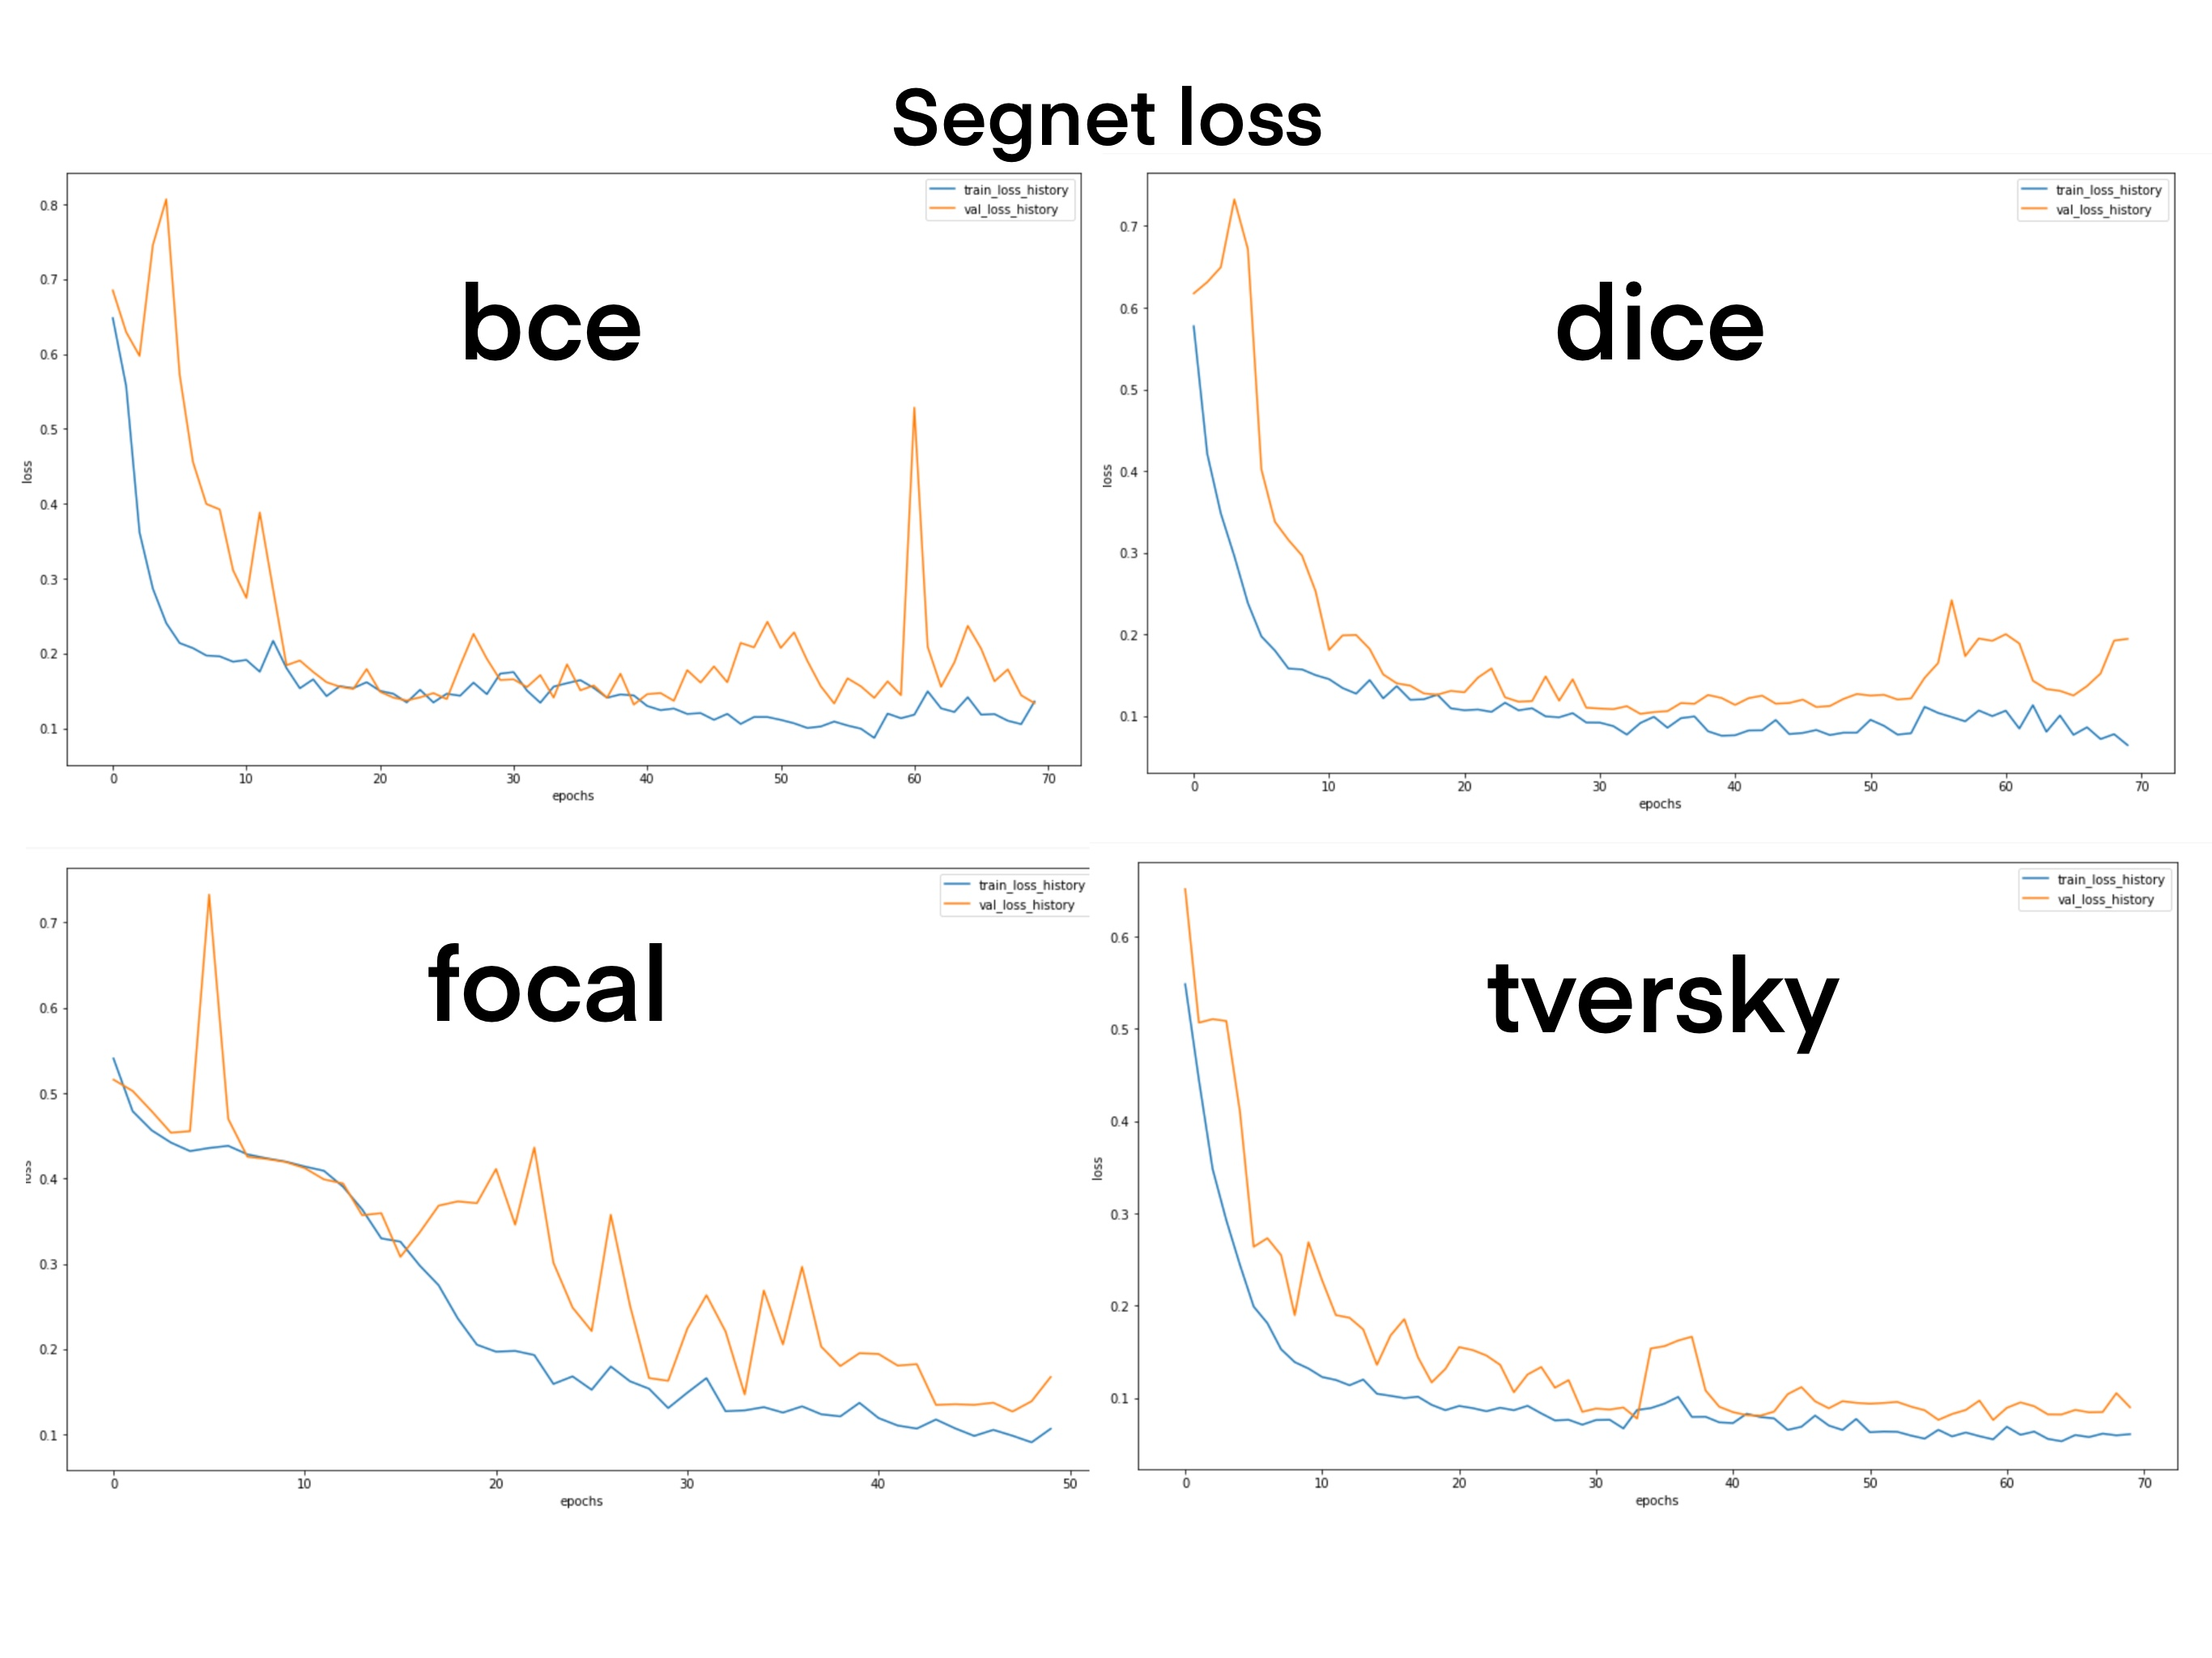

We can observe that SegNet with both BCE and Dice losses starts to overfit after around 20-30 epochs. SegNet with Focal loss and Tversky loss can be trained further without significant overfitting, but SegNet with Focal loss shows a clear overfitting tendency after 50 epochs. Therefore, I limited the training for SegNet with Focal loss to 50 epochs, as its loss behaves less stable throughout the training.

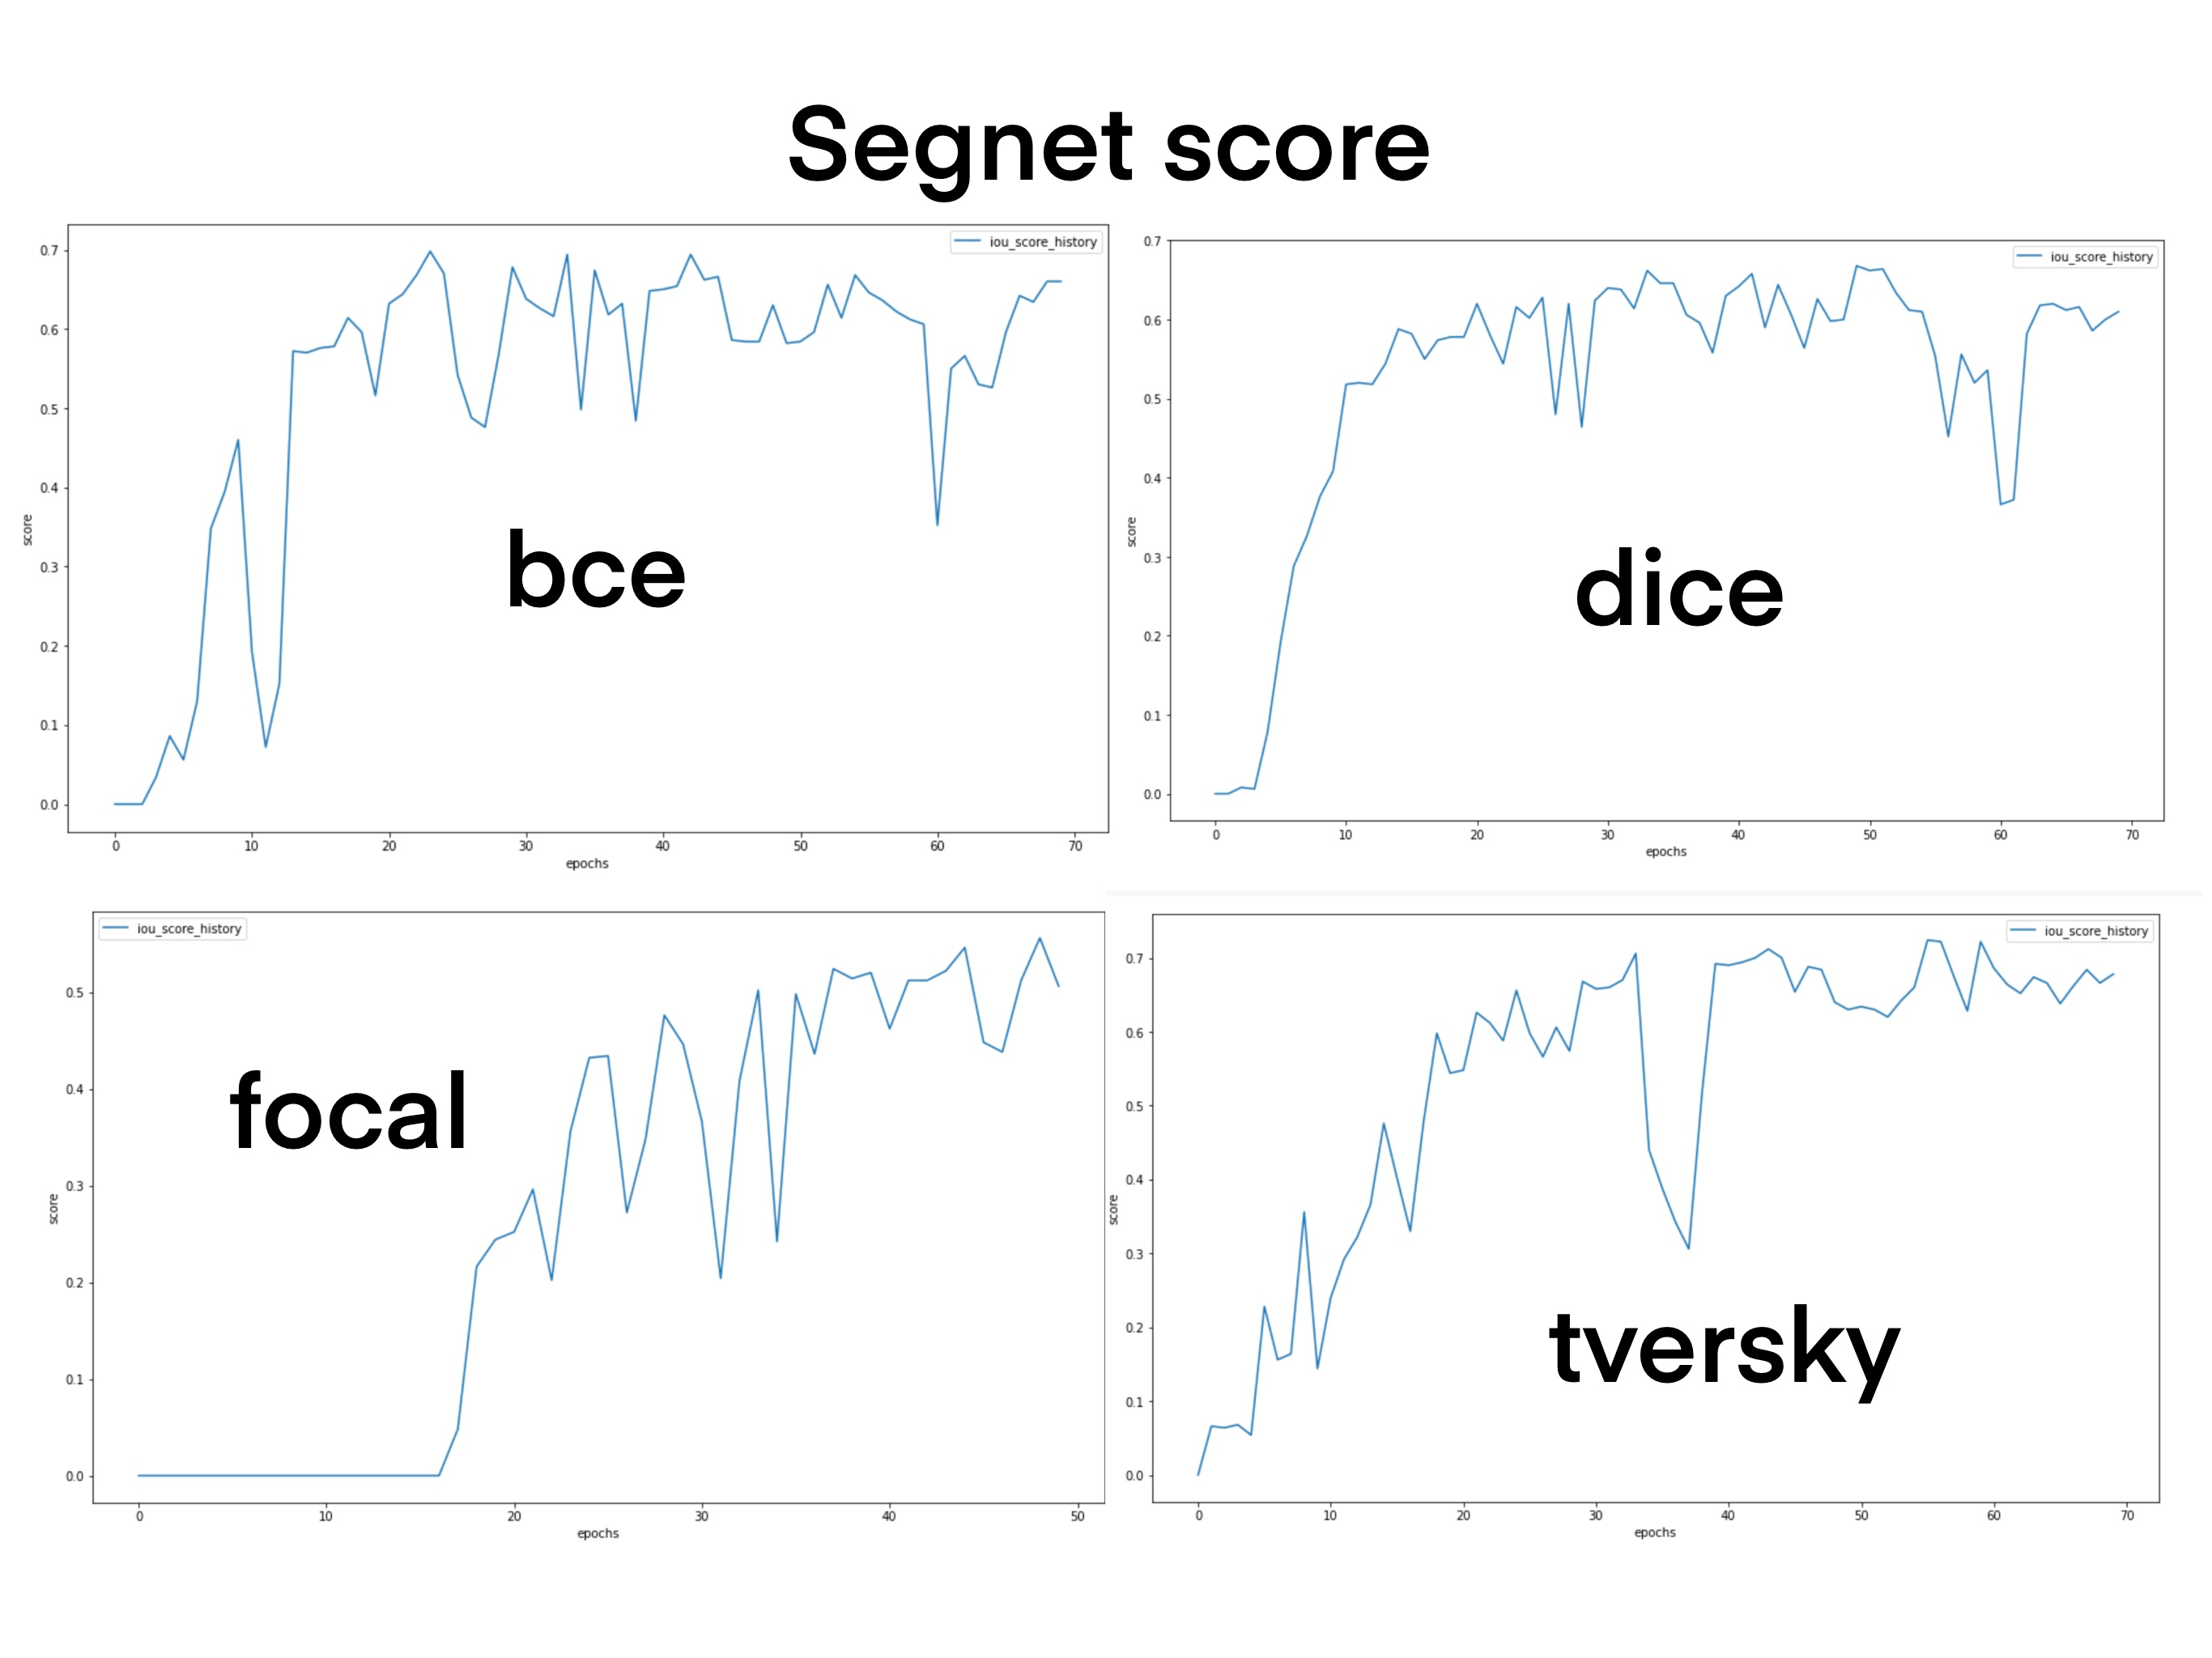

IOU score for SegNet. Here, we can note a significant lag in the model with Focal loss, and a slight lag in the model with Tversky loss. Focal loss exhibits the lowest and least stable score among the models. Dice loss achieves a score of 0.5 in just 10 epochs, showing the fastest improvement initially, but it falls behind Tversky and BCE losses with further training.

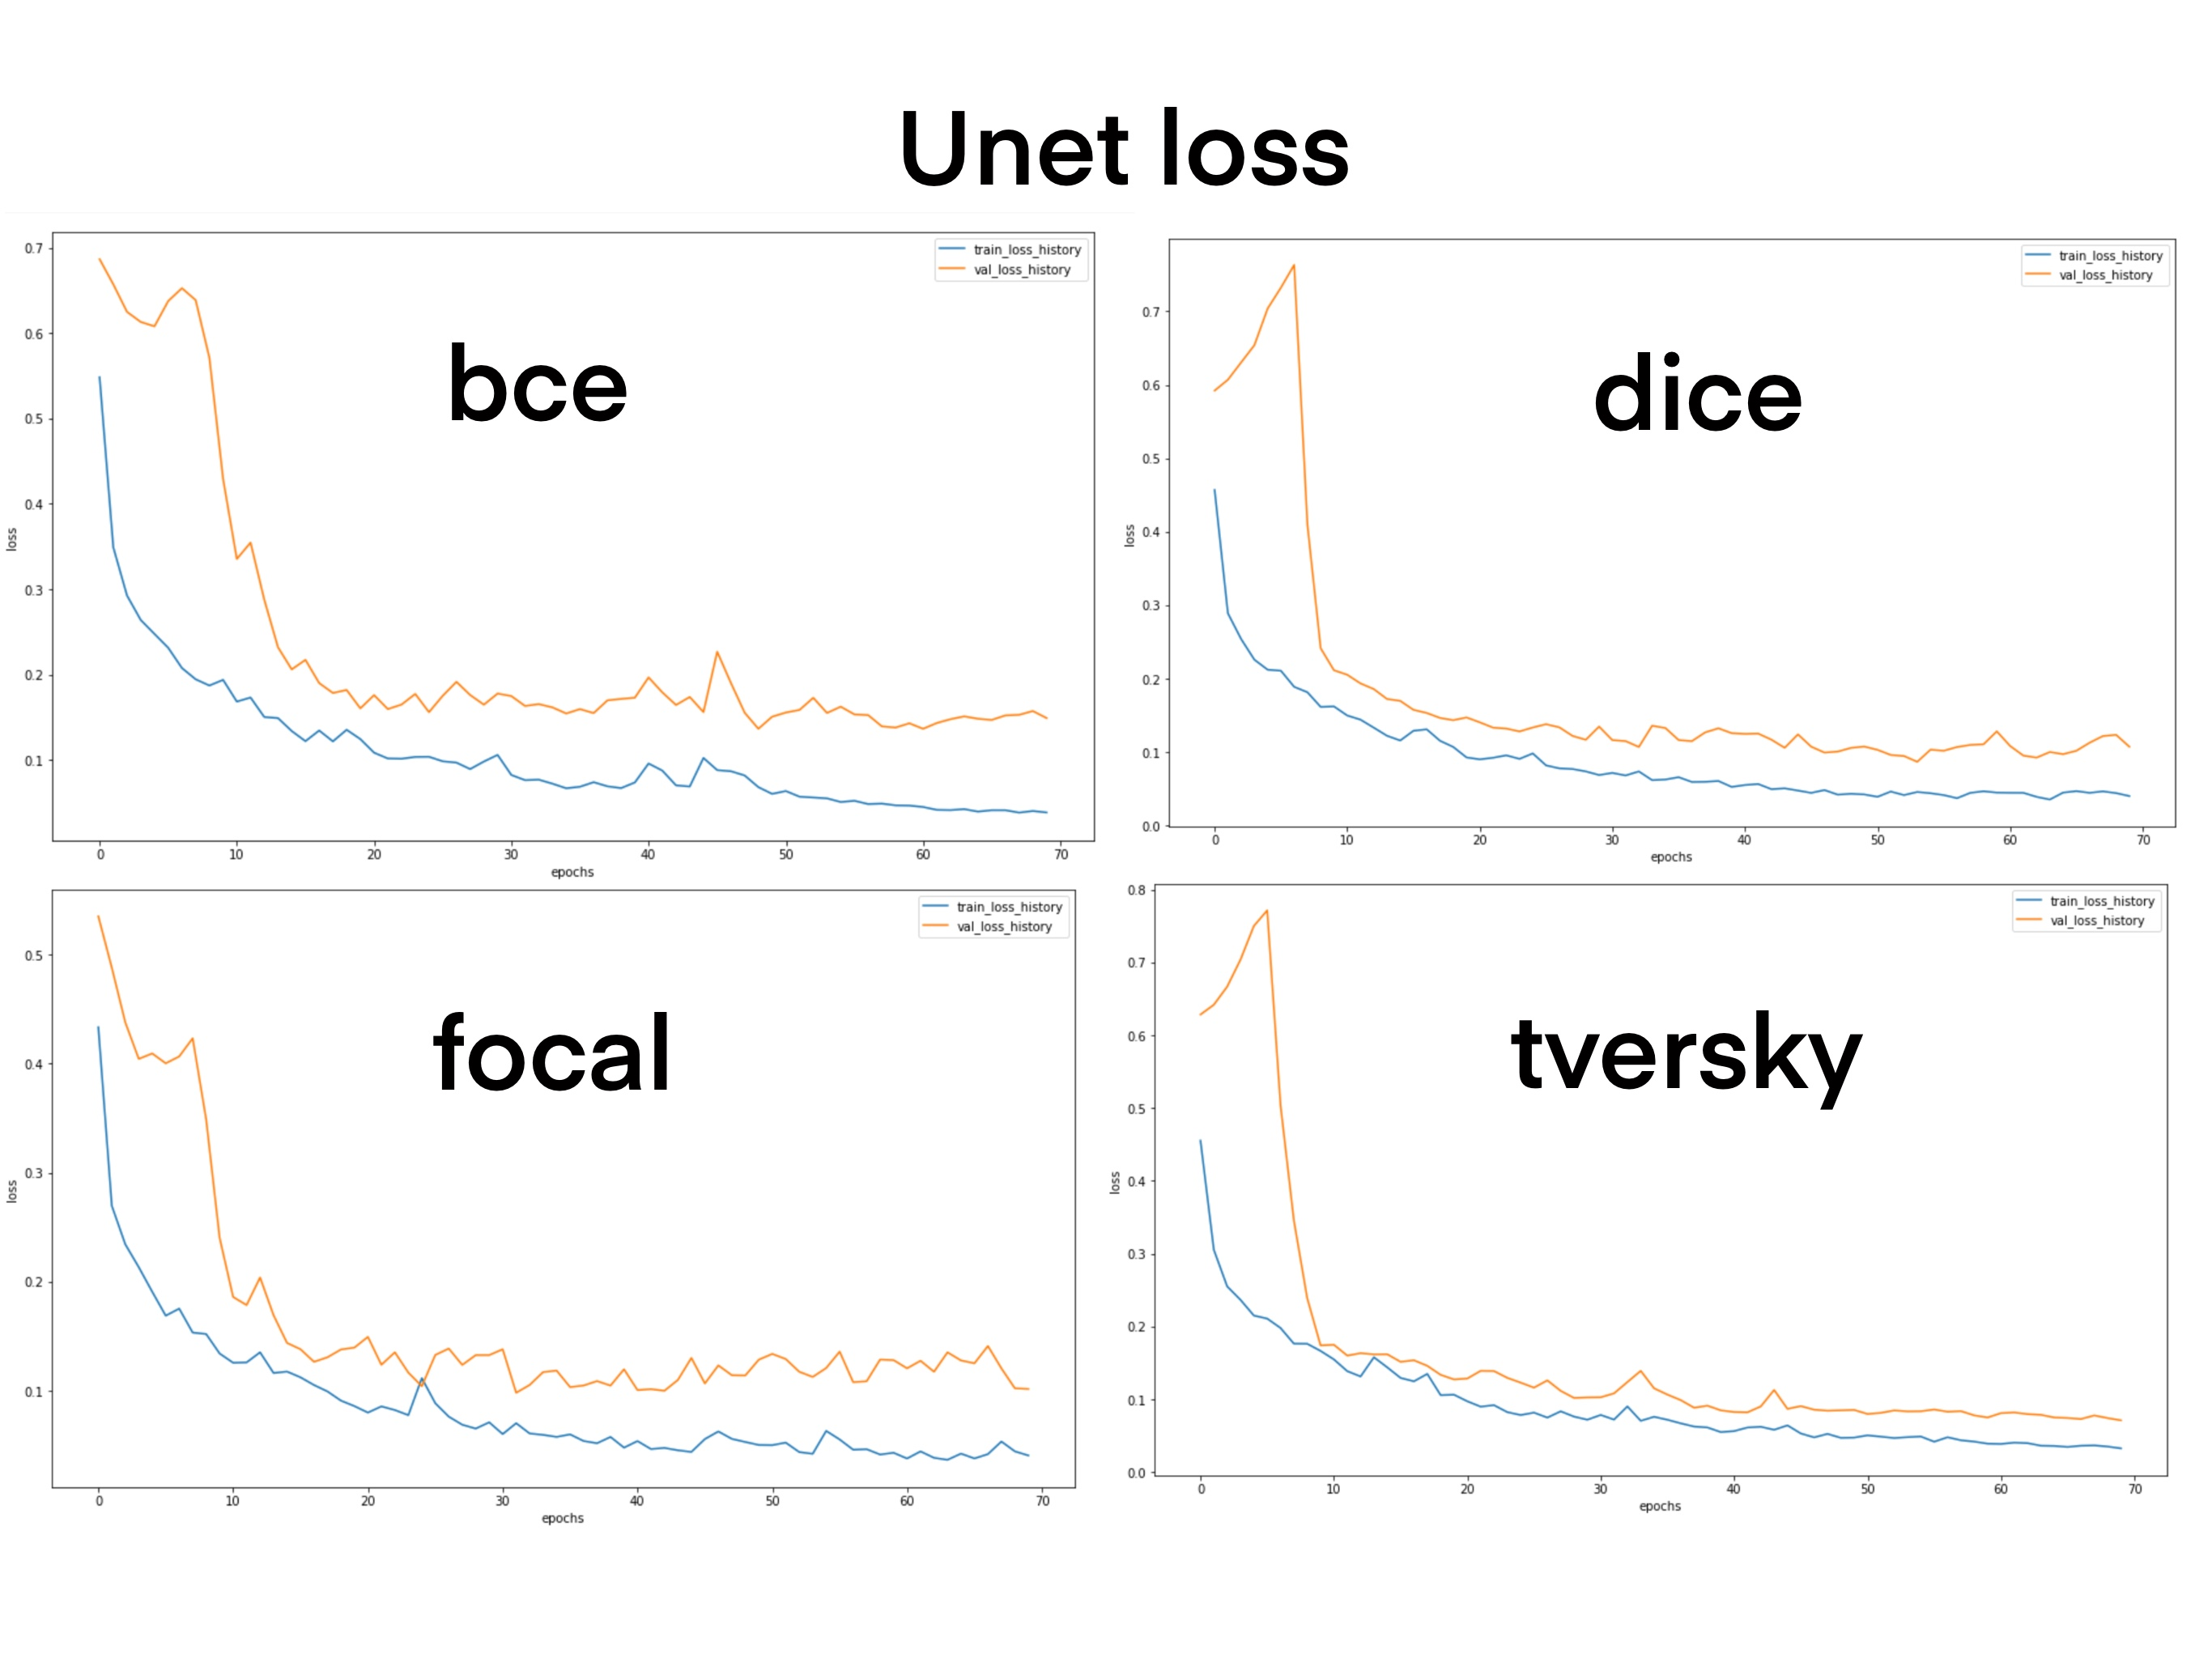

With U-Net, the training process is smoother and more stable. In contrast to SegNet, both BCE and Focal losses converge within 30-40 epochs, while Dice and Tversky losses require more than 50 epochs. Among the losses, Tversky loss performs the best, while BCE and Focal losses tend to overfit earlier.

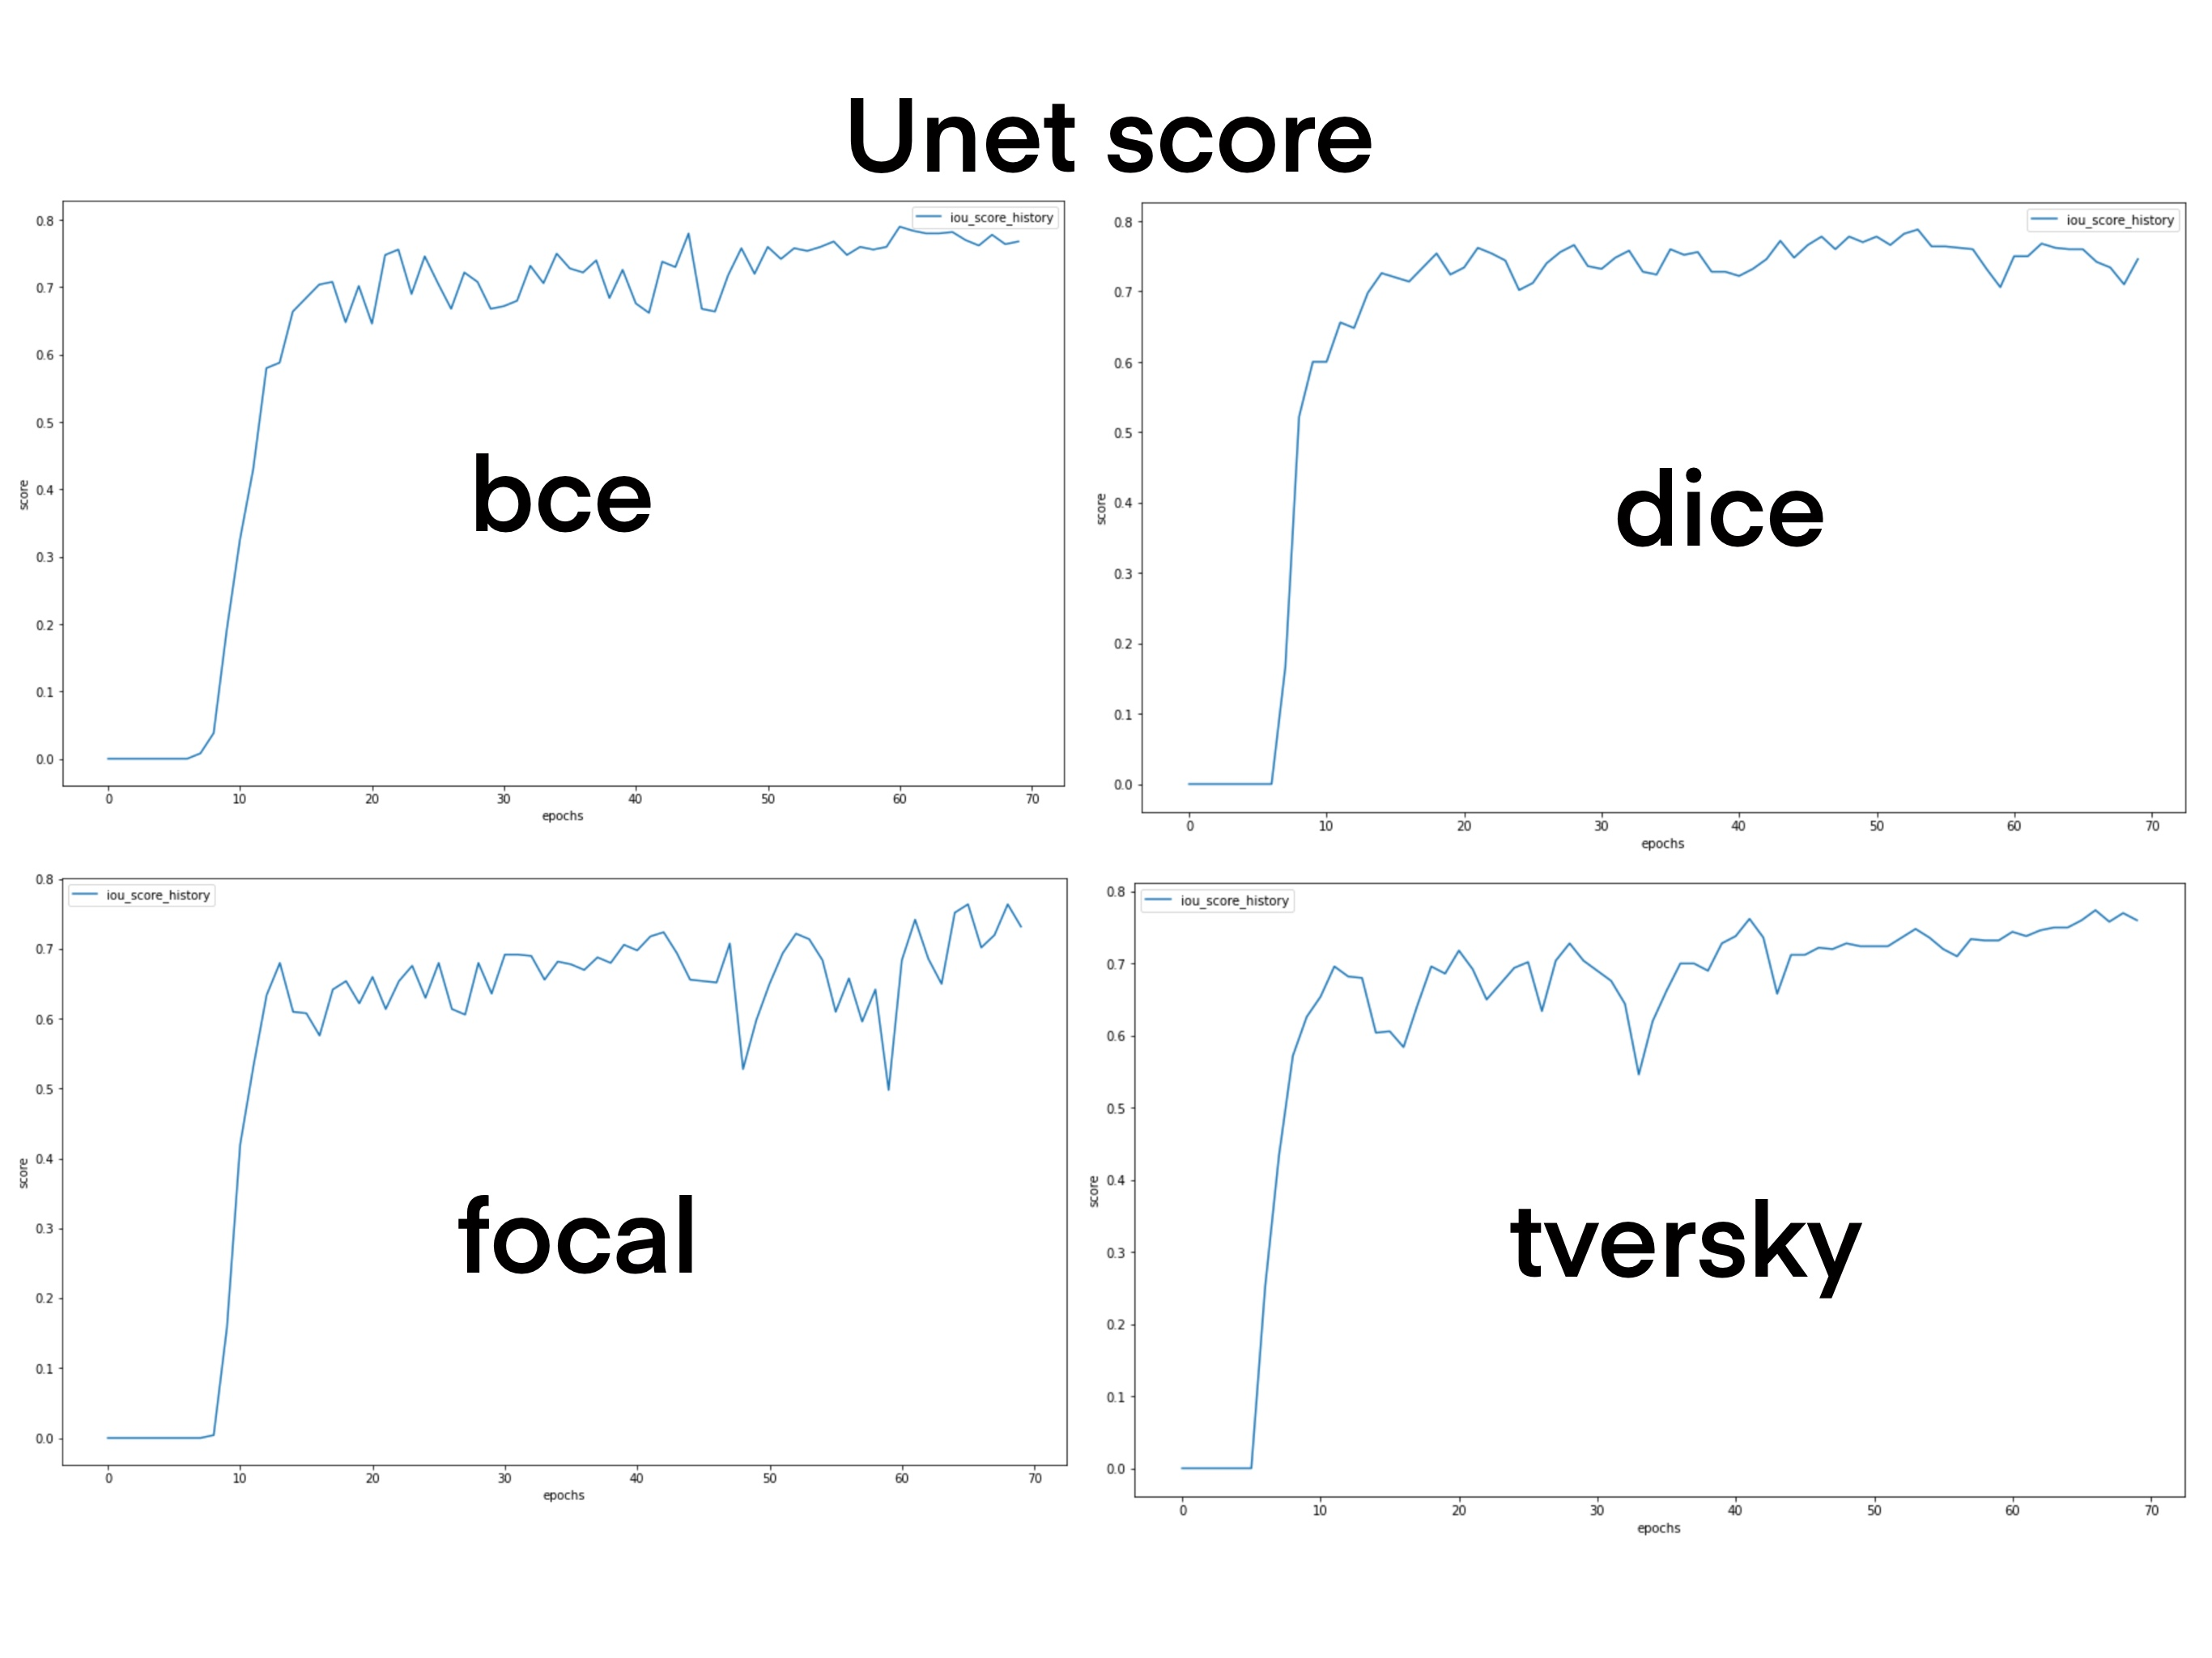

With U-Net, the performance in terms of score is significantly better than the previous model. All models achieve excellent scores around 0.7 after just 10 epochs, although U-Net with BCE loss slightly lags behind.

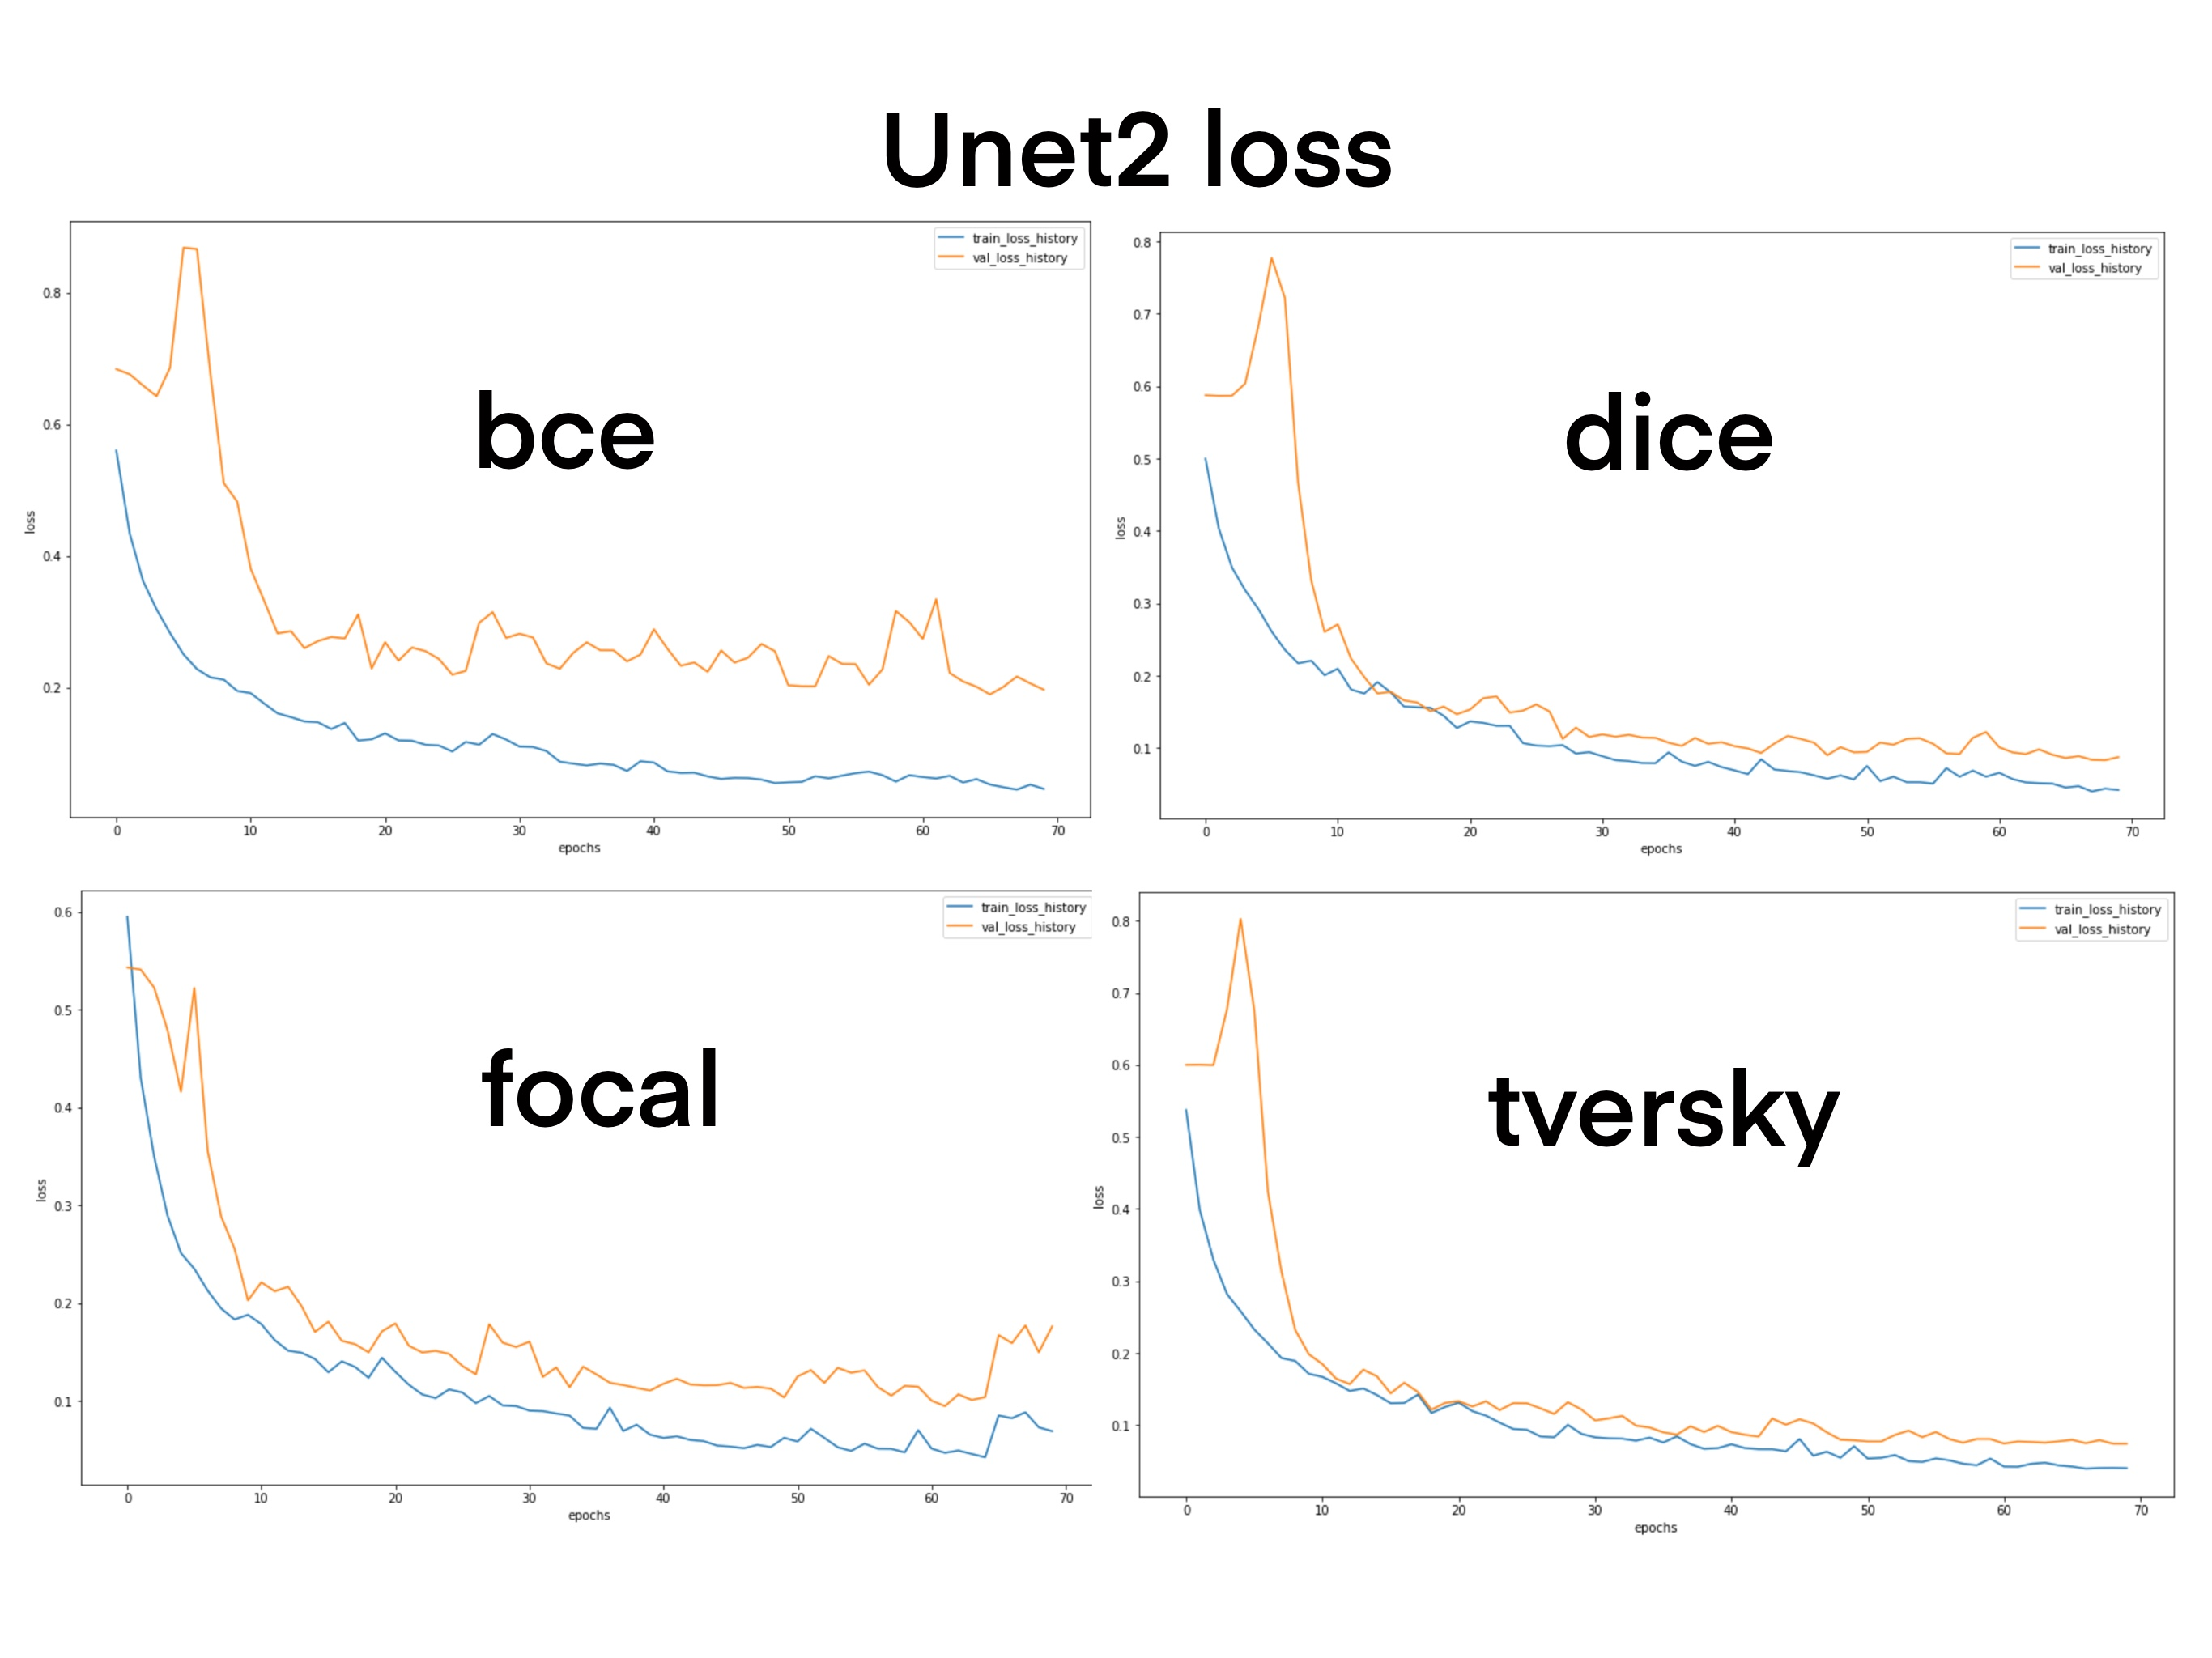

For U-Net2, the BCE loss and focal loss show instability, and the model quickly overfits after around 30 epochs. However, with the Dice loss and Tversky loss, the situation is much better, as there is no sign of overfitting even after 70 epochs.

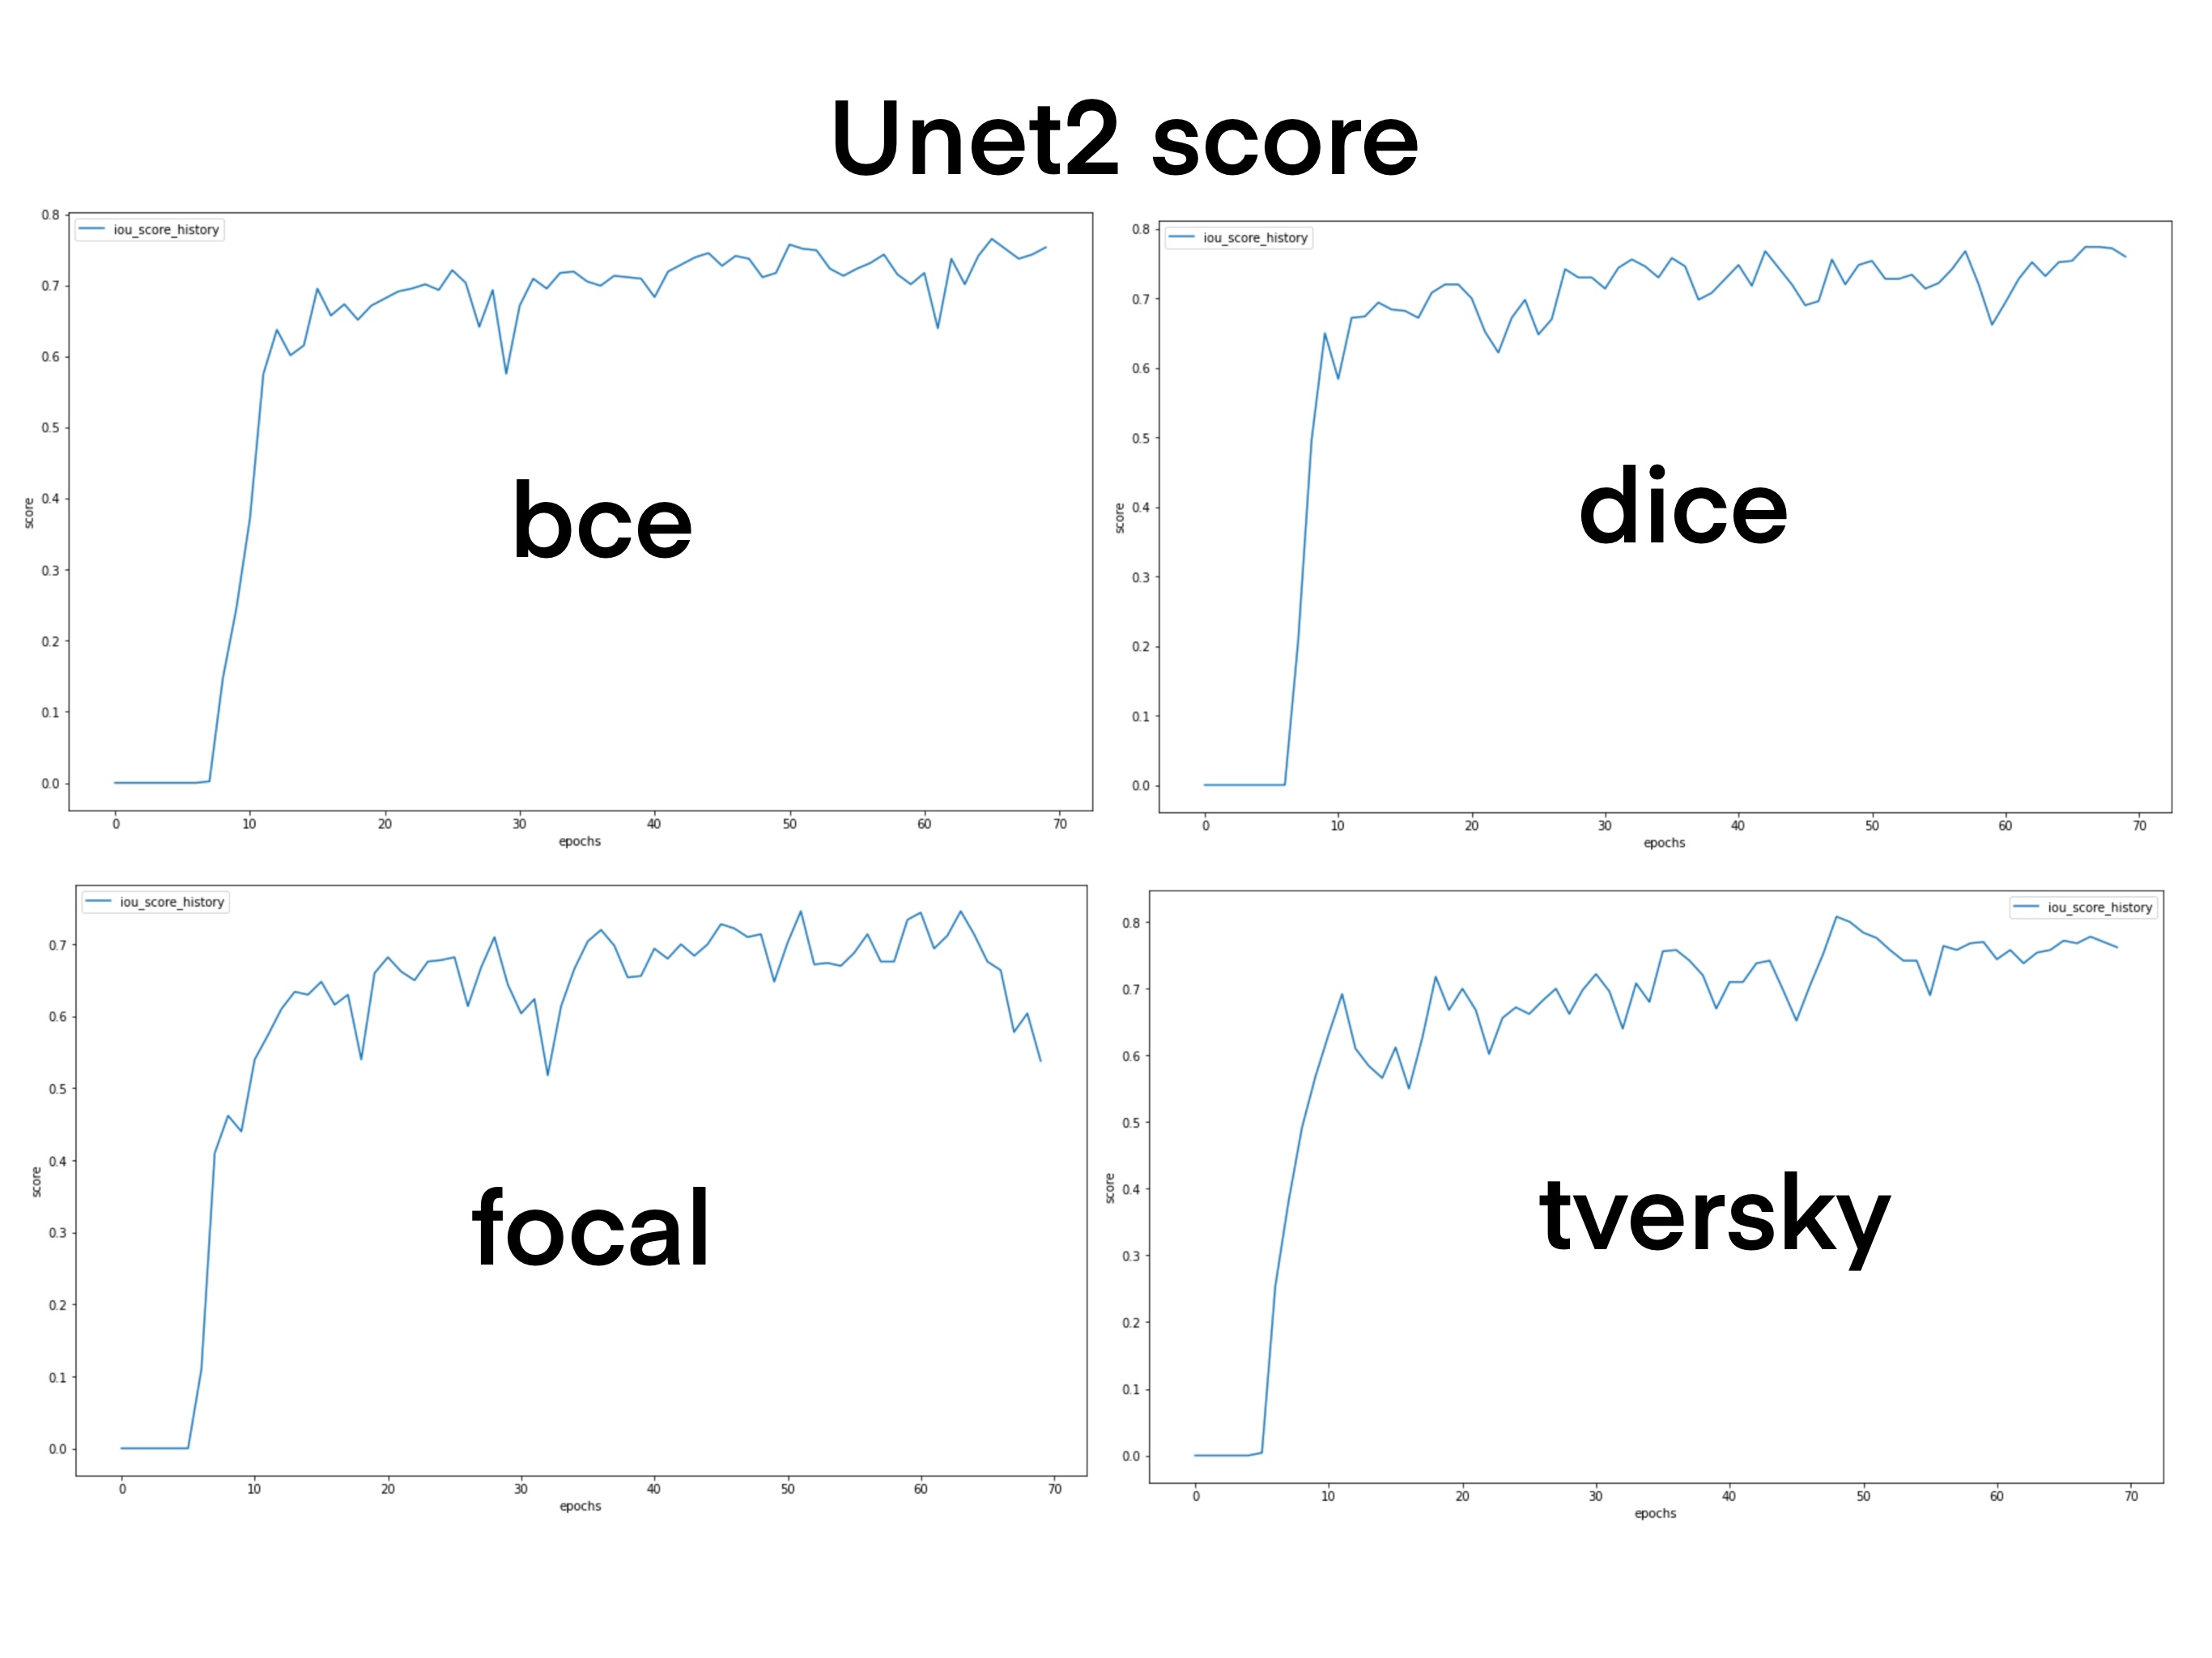

If we look at the IOU score of U-Net2 with different losses, we see a similar pattern to U-Net - after 10 epochs, the models already show a score around 0.7. However, it is worth noting that U-Net2 with focal loss shows signs of overfitting after 60 epochs.

So, which is the best model for segmenting our mole dataset? I believe it's either U-Net or U-Net2 with Tversky loss. If we train them for more than 70 epochs, they can further improve their score, which is already among the highest compared to other models and losses. Moreover, their loss curve is smoother than others, and even after 70 epochs, the model doesn't show signs of overfitting. This is in terms of quality. If training speed is important, then the U-Net model with Tversky loss outperforms, as we already see a score of 0.7+ after just 10 epochs.